# Part 1 - Introduction to Biomedical Networks
## Structuring Biomedical Data Using Networks  workshop - Network Generation

## Table of Contents

Part 1.

1. **Biomedical Networks**
   - 1.1. Libraries
   - 1.2. TCGA-LUAD project
   - 1.3. Metadata Analysis
   - 1.4. Expression Data Analysis

2. **Data Filtering and Preprocessing**
   - 2.1. Thresholding Based on Gene Expression Levels
   - 2.2. Gene Retention at Various Thresholds
   - 2.3. Thresholding Based on Gene Expression Variance
   - 2.4. Gene Retention at Different Variance Levels

3. **Gene Symbol Conversion**
   - 3.1. Checking for Missing Data and Outliers
   - 3.2. Addressing Data Heterogeneity

4. **Correlation Matrix Calculation**

5. **Graph Construction from Correlation Matrices**

6. **Network Cleaning**

7. **Sparsification Methods for Networks**

8. **Interactive Network Visualization**

9. **Storing and Managing Generated Networks**

Part 2.

10. **Patient Similarity Network Construction**

11. **DNA Methylation Network Analysis**

12. **Setting up Protein Interaction Network Using STRING Database**


# 1. Biomedical Networks

## 1.1 Libraries

In [39]:
# standard libraries
import os
import pickle

# scientific and data manipulation libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from astropy.stats import median_absolute_deviation
import mygene
import astropy

# graph and network libraries
import networkx as nx

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image
from IPython.display import display

## 1.2 TCGA-LUAD Project
- **Title**: The Cancer Genome Atlas Lung Adenocarcinoma (TCGA-LUAD)
- **Main Focus**: Study of lung adenocarcinoma (a common type of lung cancer)
- **Data Collected**: Comprehensive genomic, epigenomic, transcriptomic, and proteomic data from lung adenocarcinoma samples
- **Disease Types**:
  - Acinar Cell Neoplasms
  - Adenomas and Adenocarcinomas
  - Cystic, Mucinous, and Serous Neoplasms
- **Number of Cases**: 585 (498 with transcriptomic data)
- **Data Accessibility**: Available on the NIH-GDC Data Portal

- **Link**: [TCGA-LUAD Project Page](https://portal.gdc.cancer.gov/projects/TCGA-LUAD)

Our main focus in this notebook is on RNA-Seq based, already preprocessed gene expression data.

In [4]:
# main data directory for the project

raw_data_dir = '/data/raw'
intermediate_data_dir = '/data/intermediate'

In [5]:
# load the data from the pickle file
with open(os.path.join(raw_data_dir,"ISMB_TCGA_GE.pkl"), 'rb') as file:
    data = pickle.load(file)


Obviously this is not **yet** a graph dataset, so our first course of action is to decide how are we going to analyse this dataset. \
There are several ways we could do that, however today we are focusing on the network biology aspect of cancer genome data. \
In order to construct a biological network, we are going to first:
- examine the TCGA metadata 
- come up with useful strategies to tackle the large data size 
- create the basis of a biological network 

## 1.3 Metadata Analysis

In [6]:
print(data.keys())

dict_keys(['datExpr', 'datMeta'])


In [7]:
data["datMeta"]

patient   race  gender    sample_type cigarettes_per_day  \
_row                                                                          
TCGA-38-7271  TCGA-38-7271  white  female  Primary Tumor             1.3699   
TCGA-55-7914  TCGA-55-7914  white  female  Primary Tumor              0.274   
TCGA-95-7043  TCGA-95-7043  white  female  Primary Tumor             2.1918   
TCGA-73-4658  TCGA-73-4658  white  female  Primary Tumor             1.3699   
TCGA-86-8076  TCGA-86-8076  white    male  Primary Tumor                  0   
...                    ...    ...     ...            ...                ...   
TCGA-86-8073  TCGA-86-8073  white    male  Primary Tumor             2.1918   
TCGA-MN-A4N4  TCGA-MN-A4N4  white    male  Primary Tumor                  0   
TCGA-53-7626  TCGA-53-7626  white  female  Primary Tumor             1.9178   
TCGA-44-A47G  TCGA-44-A47G  white  female  Primary Tumor             1.5342   
TCGA-55-6969  TCGA-55-6969  white    male  Primary Tumor                  0   

              Smoked sizeFactor replaceable  
_row                                         
TCGA-38-7271  Smoker     0.5841        True  
TCGA-55-7914  Smoker     0.9873        True  
TCGA-95-7043  Smoker     0.5439        True  
TCGA-73-4658  Smoker     0.7715        True  
TCGA-86-8076   Never      1.313        True  
...              ...        ...         ...  
TCGA-86-8073  Smoker     1.9733        True  
TCGA-MN-A4N4   Never     1.0464        True  
TCGA-53-7626  Smoker     1.7208        True  
TCGA-44-A47G  Smoker     0.8926        True  
TCGA-55-6969   Never     1.4732        True  

[498 rows x 8 columns]

In [8]:
data["datMeta"]["patient"].unique().size

498

In [9]:
data["datMeta"]['sample_type'].value_counts()

sample_type
Primary Tumor          469
Solid Tissue Normal     29
Name: count, dtype: int64

/home/skamp/.conda/envs/ismbenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


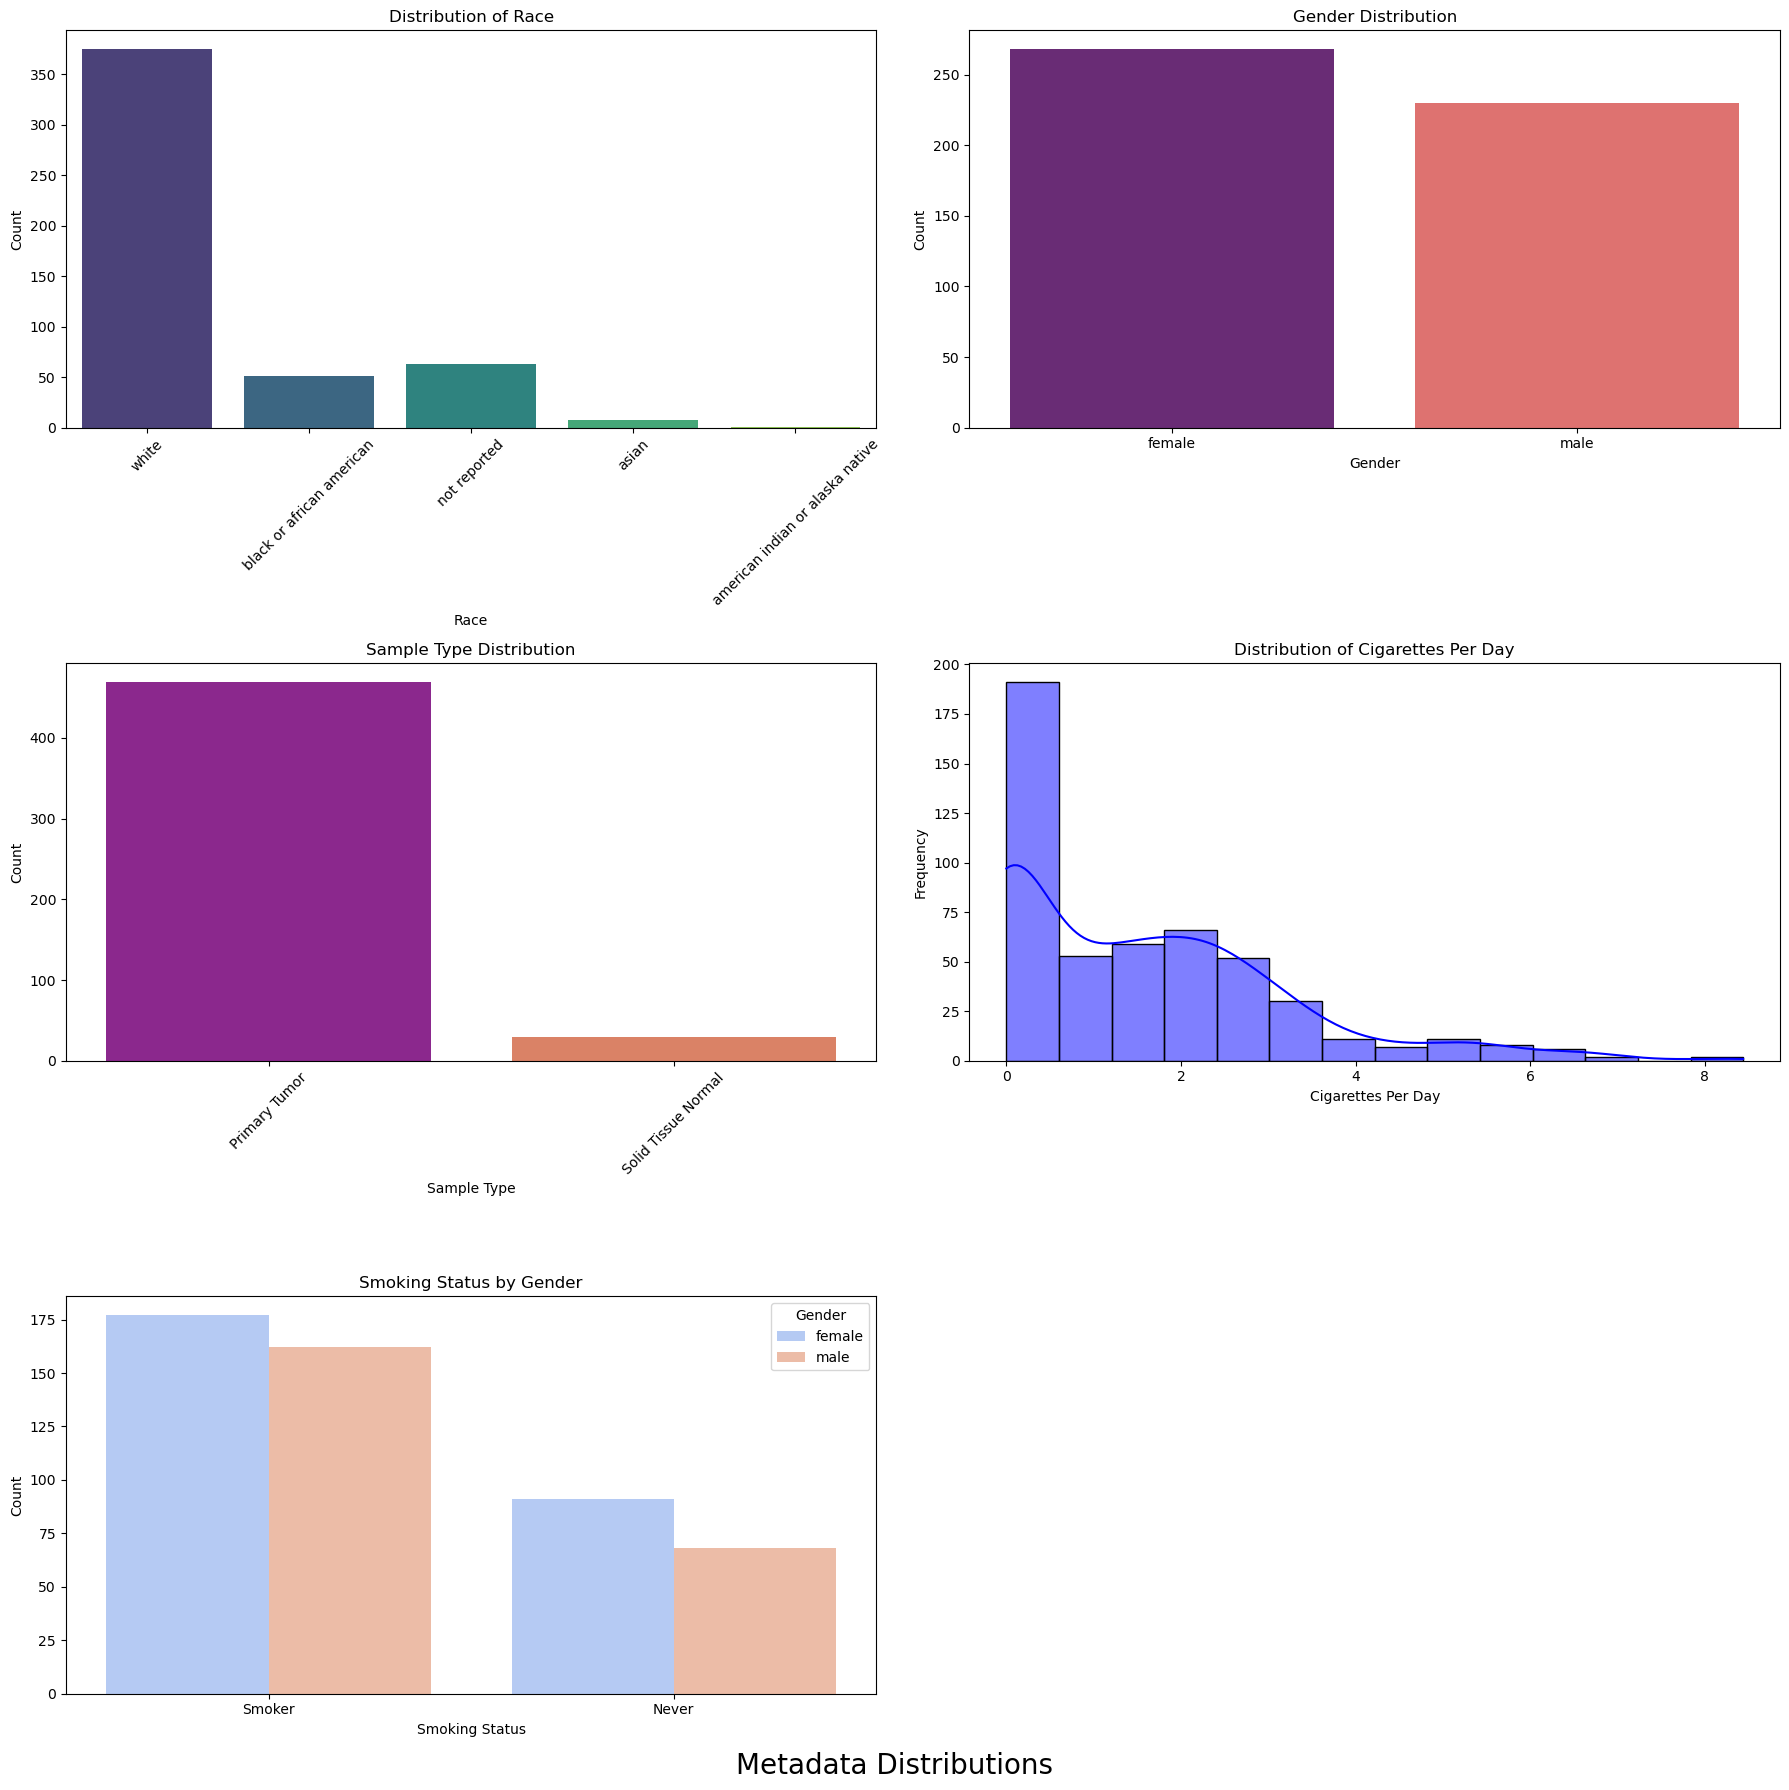

In [10]:
# Set up the figure and axes for a 2-column layout
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.suptitle('Metadata Distributions', fontsize=20, y=0)

# Plot 1: Distribution of Race
sns.countplot(ax=axes[0, 0], x='race', data=data['datMeta'], palette='viridis')
axes[0, 0].set_title('Distribution of Race')
axes[0, 0].set_xlabel('Race')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Gender Distribution
sns.countplot(ax=axes[0, 1], x='gender', data=data['datMeta'], palette='magma')
axes[0, 1].set_title('Gender Distribution')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')

# Plot 3: Sample Type Distribution
sns.countplot(ax=axes[1, 0], x='sample_type', data=data['datMeta'], palette='plasma')
axes[1, 0].set_title('Sample Type Distribution')
axes[1, 0].set_xlabel('Sample Type')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Distribution of Cigarettes Per Day
sns.histplot(ax=axes[1, 1], data=data['datMeta']['cigarettes_per_day'], kde=True, color='blue')
axes[1, 1].set_title('Distribution of Cigarettes Per Day')
axes[1, 1].set_xlabel('Cigarettes Per Day')
axes[1, 1].set_ylabel('Frequency')

# Plot 5: Smoking Status by Gender
sns.countplot(ax=axes[2, 0], x='Smoked', hue='gender', data=data['datMeta'], palette='coolwarm')
axes[2, 0].set_title('Smoking Status by Gender')
axes[2, 0].set_xlabel('Smoking Status')
axes[2, 0].set_ylabel('Count')
axes[2, 0].legend(title='Gender')

axes[2, 1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
data['datMeta'][data['datMeta']['sample_type'] == 'Primary Tumor']['Smoked'].value_counts()

Smoked
Smoker    323
Never     146
Name: count, dtype: int64

# Expression data analysis

This dataset contains gene expression levels for various samples, identified by their TCGA (The Cancer Genome Atlas) codes.  
Each row represents a different sample, while each column represents a different gene, identified by its Ensembl gene ID.  
The values in the table are the expression levels of the genes for each sample.

In [12]:
# let's create a new variable for the expression data alone, just for ease of use, and then inspect it
expression_data = data["datExpr"]
expression_data

_row         ENSG00000000003.15 ENSG00000000419.13 ENSG00000000457.14  \
TCGA-38-7271            11.3668            10.3673             9.7884   
TCGA-55-7914            11.5434            10.5282             9.7292   
TCGA-95-7043             11.411            11.2018             9.4449   
TCGA-73-4658            12.2149            10.3249              9.234   
TCGA-86-8076            11.2882            10.2095             9.8186   
...                         ...                ...                ...   
TCGA-86-8073            10.7676            10.5503             9.0277   
TCGA-MN-A4N4             11.656            11.0739             9.5578   
TCGA-53-7626            10.8912            10.1742             9.6307   
TCGA-44-A47G              11.32             9.9137             9.3312   
TCGA-55-6969            10.5764            10.9022             9.3425   

_row         ENSG00000000460.17 ENSG00000000938.13 ENSG00000000971.16  \
TCGA-38-7271             8.2552            10.6173            12.8447   
TCGA-55-7914             7.9951             8.4858            10.4696   
TCGA-95-7043             8.3546             7.3211            10.7856   
TCGA-73-4658             7.7537            11.0656            12.3631   
TCGA-86-8076             7.9844            10.5213            13.7848   
...                         ...                ...                ...   
TCGA-86-8073             8.2811             9.9471            11.8641   
TCGA-MN-A4N4             8.7883             8.9532            11.0791   
TCGA-53-7626             8.0179            10.6328             11.247   
TCGA-44-A47G             7.8703            11.3029            12.8687   
TCGA-55-6969             8.8147             9.6115            12.3155   

_row         ENSG00000001036.14 ENSG00000001084.13 ENSG00000001167.14  \
TCGA-38-7271            10.8836            10.4437            10.8112   
TCGA-55-7914            10.4737             7.9065            11.8983   
TCGA-95-7043            11.6185            14.1836            10.8329   
TCGA-73-4658            10.9023              10.06            11.2092   
TCGA-86-8076            11.2318            10.8315            10.5784   
...                         ...                ...                ...   
TCGA-86-8073             11.237            14.2843            10.9497   
TCGA-MN-A4N4            10.5202             11.331            11.3659   
TCGA-53-7626            10.4815             9.8428            10.5795   
TCGA-44-A47G            11.2659            12.4677            10.9404   
TCGA-55-6969             11.216            11.1273             10.311   

_row         ENSG00000001460.18  ... ENSG00000288586.1 ENSG00000288596.2  \
TCGA-38-7271             9.1178  ...            4.4411            5.6909   
TCGA-55-7914             8.5842  ...             4.768            8.0948   
TCGA-95-7043             8.8155  ...            4.2248            7.3539   
TCGA-73-4658             9.0663  ...            4.2146            6.0253   
TCGA-86-8076             9.6428  ...            4.7844            6.8675   
...                         ...  ...               ...               ...   
TCGA-86-8073             8.8266  ...            4.2611             7.157   
TCGA-MN-A4N4             8.8701  ...            4.3317            7.6037   
TCGA-53-7626               9.86  ...            5.6458            6.6984   
TCGA-44-A47G             9.4188  ...            4.6125            8.0939   
TCGA-55-6969              9.123  ...            5.9603            7.2623   

_row         ENSG00000288598.1 ENSG00000288611.1 ENSG00000288612.1  \
TCGA-38-7271            3.8172            5.5378            4.5573   
TCGA-55-7914            4.2182            3.5233             4.975   
TCGA-95-7043            5.0121            4.2248            4.8311   
TCGA-73-4658            3.8231            4.0984            4.6727   
TCGA-86-8076            4.5078            2.4821            5.1468   
...                        ...      

498 rows × 22637 columns is a quite large matrix, thus we have to consider reducing the dimensionality.


# 2. Data Filtering and Preprocessing
Ideas?  
- Filter by Mean Expression: Select genes with high mean expression levels

- Filter by Variance: Select genes with high variance across samples, as low variance genes might not contribute significantly to the analysis.


We are doing this to make sure our computations are  
- computationally efficient,  
- the network complexity is manageable,  
- the biological signal is enhanced thus we make sure our analysis is biologically relevant.

In [13]:
# A few preliminary steps that might be useful for data cleaning and preprocessing
# Ensure all columns are numeric
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')

# Drop columns that could not be converted to numeric (if any)
expression_data = expression_data.dropna(axis=1, how='all')

In [14]:
# In case we want to check the shape of the data further down the line
expression_data.shape

(498, 22637)

In [15]:
# Checking for duplicate rows and columns
print(f"Number of duplicate indices: {expression_data.index.duplicated().sum()}")  
print(f"Number of duplicate columns: {expression_data.columns.duplicated().sum()}") 

Number of duplicate indices: 0
Number of duplicate columns: 0


## 2.1 Analysing Gene Expression Levels

/home/skamp/.conda/envs/ismbenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


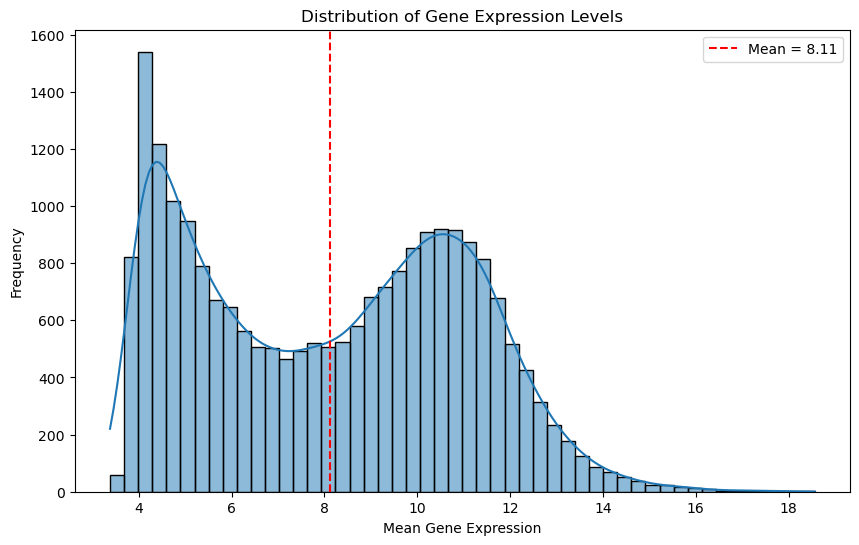

In [16]:
# Plot the distribution of gene expression levels 

# Calculate the mean expression level for each gene
gene_means = expression_data.mean(axis=0)

# Plot the distribution of gene expression levels
plt.figure(figsize=(10, 6))
sns.histplot(gene_means, bins=50, kde=True)
plt.xlabel('Mean Gene Expression')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Expression Levels')

# mean of the gene means
threshold = gene_means.mean()
plt.axvline(threshold, color='red', linestyle='--', label=f'Mean = {threshold:.2f}')
plt.legend()

plt.show()

The histogram shows the frequency of genes at different mean expression levels.  
Dashed red line shows the mean of the mean gene expression.  (8.11)  
The histogram show a bimodal distribution - does this mean two groups of genes?  
Some genes are consistently expressed at lower levels (housekeeping genes?), while others are expressed at higher levels. 
  
We could use this for thresholding, however it is not informative about the variability of the genes.

Still, let's inspect how many genes would retain in our dataset at different expression thresholds.

In [17]:
# Function to filter out low-expressed genes
def filter_low_expression_genes(data, threshold=1.0):
    # Calculate the mean expression for each gene
    gene_means = data.mean(axis=0)
    # Filter out genes with mean expression below the threshold
    mask = gene_means >= threshold
    filtered_data = data.loc[:, mask]
    return filtered_data

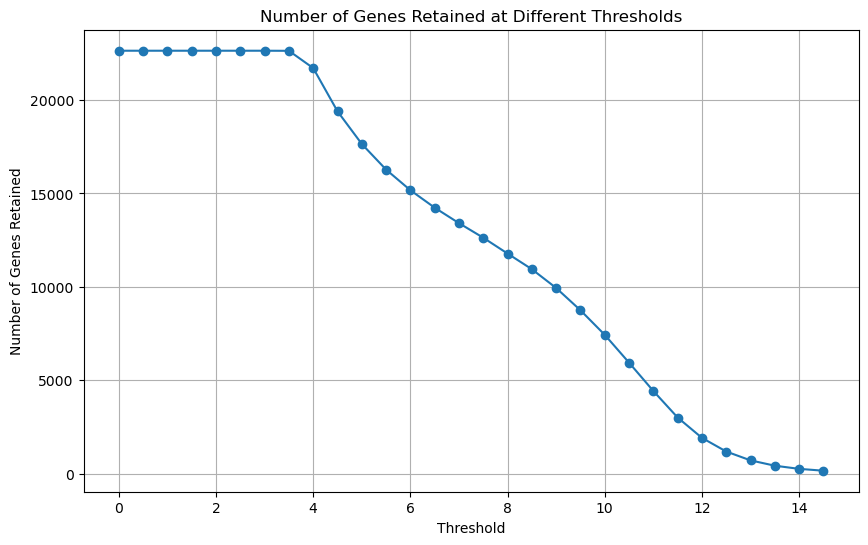

In [18]:
# Gene Retention at Various Thresholds
# Define a range of thresholds
thresholds = np.arange(0, 15, 0.5)

# List to store the number of genes retained at each threshold
num_genes = []

# Assuming df_renamed is your DataFrame with gene expression data
for threshold in thresholds:
    df_filtered = filter_low_expression_genes(expression_data, threshold)
    num_genes.append(df_filtered.shape[1])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, num_genes, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of Genes Retained')
plt.title('Number of Genes Retained at Different Thresholds')
plt.grid(True)
plt.show()

In [19]:
# Assign the filtered data to a new variable
# df_filtered_expression = filter_low_expression_genes(expression_data, threshold=9)
# print(f"Filtered data shape: {df_filtered_expression.shape}")  # Check the new shape to confirm filtering

## 2.3 Thresholding Based on Gene Expression Variance


1. High-dimensional data can be computationally expensive to process.

2. Genes with higher variance across samples are likely to be more biologically relevant.

3. Low-variance genes often represent housekeeping genes or noise. 



### Task 1: Variance-Based Gene Filtering

Write a function that takes in a dataframe and a threshold value as argument, and call it filter_high_variance_genes()

#### Step 1: Calculate Variance
Compute the variance of expression levels for each gene across all samples.

#### Step 2: Set a Variance Threshold
Determine a threshold for variance. Genes with variance below this threshold are considered to have low variance and can be filtered out.

#### Step 3: Filter Genes
Retain only those genes with variance above the threshold for network construction.


In [19]:
def filter_high_variance_genes(data, threshold):
    """
    Filters out genes (columns) with variance below the specified threshold.

    Parameters:
    data (pd.DataFrame): DataFrame with gene expression data where rows are samples and columns are genes.
    threshold (float): Minimum variance level to keep a gene.

    Returns:
    pd.DataFrame: Filtered DataFrame with genes having variance above the threshold.
    """
    # Calculate the variance for each gene (column)
    gene_variances = data.var(axis=0)
    # Create a boolean mask to filter out genes with variance below the threshold
    mask = gene_variances >= threshold
    # Apply the mask to filter the DataFrame
    filtered_data = data.loc[:, mask]
    return filtered_data


## 2.4 Gene Retention at Different Variance Levels

Idea:  

Visualise the gene retention at different thresholds.  
 
Calculate the 75th percentile of the variance distribution, and use it as a threshold.  
It is a good balance between retaining enough data for meaningful analysis and removing low-variance noise

Chosen Variance Threshold: 1.2018901296749187


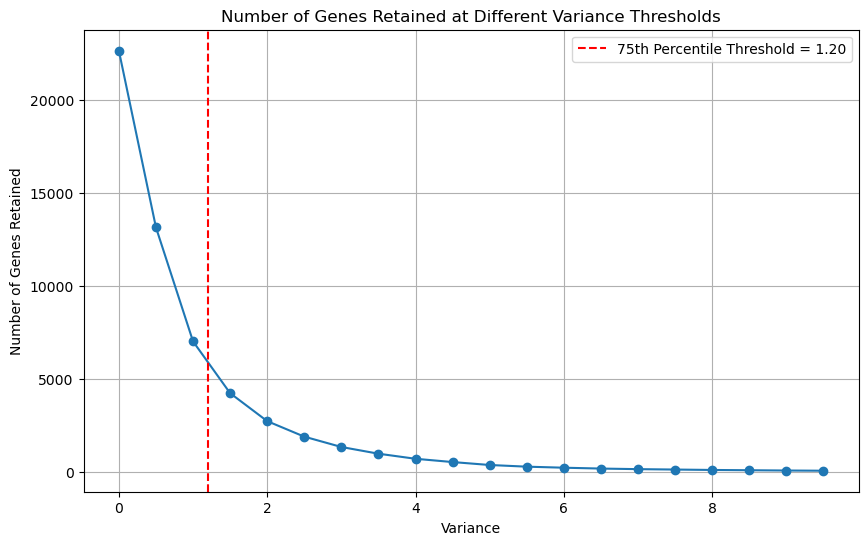

In [20]:
# Define a range of variance thresholds
variance_thresholds = np.arange(0, 10, 0.5)

# List to store the number of genes retained at each threshold
num_genes = []

# Assuming df_renamed is your DataFrame with gene expression data
for threshold in variance_thresholds:
    df_filtered = filter_high_variance_genes(expression_data, threshold)
    num_genes.append(df_filtered.shape[1])

# Calculate the variance for each gene
gene_variances = expression_data.var(axis=0)
# Calculate the 75th percentile of the variance distribution
variance_threshold = np.percentile(gene_variances, 75)
print(f"Chosen Variance Threshold: {variance_threshold }")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(variance_thresholds, num_genes, marker='o')
plt.axvline(variance_threshold, color='red', linestyle='--', label=f'75th Percentile Threshold = {variance_threshold:.2f}')
plt.xlabel('Variance')
plt.ylabel('Number of Genes Retained')
plt.legend()
plt.title('Number of Genes Retained at Different Variance Thresholds')
plt.grid(True)
plt.show()

Let's assign this value as threshold to focus on genes with higher variance.

In [21]:
# Assign the filtered data to a new variable
# Focusing on the top quartile (75th percentile) of genes with the highest variance
df_filtered_variance = filter_high_variance_genes(expression_data, threshold = 1.2)
print(f"Filtered data shape: {df_filtered_variance.shape}")  # Check the new shape to confirm filtering

Filtered data shape: (498, 5671)


In [ ]:
# df_filtered_variance.describe()

# 3. Gene Symbol Conversion: ENSG to HGCN

Converting Ensembl gene IDs (ENSG) to HGNC (HUGO Gene Nomenclature Committee) gene symbols is often a good practice as HGCN is  
- standard identifier,  
- more human readable,  
- is widely used in publications, thus helps domain experts understand more effectively the analysis.

We are using for this conversion the `mygene` package. [DOC](https://docs.mygene.info/projects/mygene-py/en/latest/)

In [22]:
def rename_ensembl_to_gene_names(df, chunk_size=1000):
    """
    Renames Ensembl gene IDs to gene names using mygene.
    
    Parameters:
    df (pd.DataFrame): DataFrame with Ensembl gene IDs as columns.
    chunk_size (int): Number of Ensembl IDs to query at a time.
    
    Returns:
    pd.DataFrame: DataFrame with gene names as columns, excluding genes that couldn't be mapped.
    """
    
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Remove the `.number` suffix from ENSG IDs
    df_copy.columns = df_copy.columns.str.split('.').str[0]

    # Initialize mygene client
    mg = mygene.MyGeneInfo()

    # Split ENSG IDs into smaller chunks
    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    ensg_ids = df_copy.columns.tolist()
    gene_mappings = []

    for chunk in chunks(ensg_ids, chunk_size):
        result = mg.querymany(chunk, scopes='ensembl.gene', fields='symbol', species='human')
        gene_mappings.extend(result)

    # Create a mapping from ENSG to gene symbol, handle missing mappings
    ensg_to_gene = {item['query']: item.get('symbol', None) for item in gene_mappings}
    
    # Log the unmapped genes
    unmapped_genes = [gene for gene in ensg_ids if ensg_to_gene.get(gene) is None]
    if unmapped_genes:
        print(f"Unmapped genes: {unmapped_genes}")

    # Filter out genes that couldn't be mapped
    mapped_columns = [ensg_to_gene[ensg] for ensg in df_copy.columns if ensg_to_gene[ensg] is not None]

    # Filter the DataFrame to only include columns that have been mapped
    df_filtered = df_copy.loc[:, df_copy.columns.isin(ensg_to_gene.keys())]

    # Further filter to ensure we have the same number of columns as mapped gene names
    df_filtered = df_filtered.loc[:, [ensg for ensg in df_filtered.columns if ensg_to_gene[ensg] is not None]]

    # Assign new column names
    df_filtered.columns = [ensg_to_gene[ensg] for ensg in df_filtered.columns]

    # Handle duplicate gene names by aggregating them (e.g., by taking the mean)
    df_final = df_filtered.T.groupby(df_filtered.columns).mean().T

    return df_final

In [23]:
# convert the ensembl gene IDs to gene names
df_renamed = rename_ensembl_to_gene_names(df_filtered_variance)

1 input query terms found no hit:	['ENSG00000168078']
1 input query terms found no hit:	['ENSG00000180525']
2 input query terms found no hit:	['ENSG00000236740', 'ENSG00000239467']
9 input query terms found no hit:	['ENSG00000256618', 'ENSG00000259820', 'ENSG00000259834', 'ENSG00000261068', 'ENSG00000261534', 'ENS


Unmapped genes: ['ENSG00000166104', 'ENSG00000168078', 'ENSG00000180525', 'ENSG00000189229', 'ENSG00000197476', 'ENSG00000203635', 'ENSG00000204584', 'ENSG00000213058', 'ENSG00000214776', 'ENSG00000214797', 'ENSG00000215146', 'ENSG00000217801', 'ENSG00000218048', 'ENSG00000218175', 'ENSG00000218274', 'ENSG00000218617', 'ENSG00000220154', 'ENSG00000222000', 'ENSG00000223829', 'ENSG00000223931', 'ENSG00000224251', 'ENSG00000224585', 'ENSG00000224945', 'ENSG00000226025', 'ENSG00000226286', 'ENSG00000226468', 'ENSG00000226668', 'ENSG00000226816', 'ENSG00000227619', 'ENSG00000227755', 'ENSG00000228113', 'ENSG00000228477', 'ENSG00000228509', 'ENSG00000228613', 'ENSG00000229312', 'ENSG00000229896', 'ENSG00000229970', 'ENSG00000230623', 'ENSG00000230628', 'ENSG00000230699', 'ENSG00000230882', 'ENSG00000231331', 'ENSG00000231533', 'ENSG00000231703', 'ENSG00000231881', 'ENSG00000231892', 'ENSG00000231990', 'ENSG00000232006', 'ENSG00000232949', 'ENSG00000234156', 'ENSG00000234648', 'ENSG000002355

In [24]:
# Let's check the new shape of the data after renaming
print("Shape of df_filtered_variance:", df_filtered_variance.shape)
print("Shape of df_renamed:", df_renamed.shape)

Shape of df_filtered_variance: (498, 5671)
Shape of df_renamed: (498, 5338)


What could this mean?  

The output of the `mygene` and the different number of rows indicate that some of the genes werent mapped to a gene ID or multiple were mapped to the same gene ID.\
In the first case we disregard those genes, in the second we calculate the mean expression value.

In [25]:
# let's inspect the first few rows of the renamed DataFrame
df_renamed

A2M   A2ML1   A4GALT  AACSP1   AADAC  AADACP1    AARD  \
TCGA-38-7271  17.7492  4.4411  10.1862  3.5845  9.6415   3.5845  8.0089   
TCGA-55-7914  14.8513  4.4530   8.9312  3.6762  6.5685   3.6762  6.8983   
TCGA-95-7043  14.1691  4.5026   9.0834  3.8623  5.5634   8.0183  3.6226   
TCGA-73-4658  16.7238  3.1704   9.1443  2.4821  4.3206   3.6533  4.8856   
TCGA-86-8076  15.6783  4.7422   9.5150  3.2271  7.2321   5.1146  7.2174   
...               ...     ...      ...     ...     ...      ...     ...   
TCGA-86-8073  16.3773  4.0817   9.4234  6.6519  6.7641   4.2611  7.1467   
TCGA-MN-A4N4  14.9411  6.7210  11.9107  8.8283  3.4947   3.0746  4.1736   
TCGA-53-7626  16.7343  5.2575   9.5379  2.4821  5.7120   5.0910  5.6287   
TCGA-44-A47G  15.6622  3.7345   9.8660  4.1045  6.2214   4.9759  4.2980   
TCGA-55-6969  14.8136  4.3058   9.7702  6.8425  5.2016   3.9293  7.1699   

                 AASS   AATBC     AATK  ...    ZNF90     ZP3   ZPLD1  ZPLD2P  \
TCGA-38-7271  11.2890  6.8710   8.6552  ...   6.1774  6.9127  4.9403  3.5845   
TCGA-55-7914  10.5920  7.9894   8.2660  ...   9.9162  7.9426  2.4821  2.4821   
TCGA-95-7043  10.5600  7.5223   8.8214  ...   5.3150  5.8224  3.6226  3.2988   
TCGA-73-4658  10.5574  6.0253   7.8940  ...   4.6727  6.9805  5.4212  3.6533   
TCGA-86-8076  10.3567  7.2467  10.4765  ...   4.8254  7.9800  3.6417  3.9275   
...               ...     ...      ...  ...      ...     ...     ...     ...   
TCGA-86-8073  11.3497  7.0724   8.7741  ...   8.6449  9.2445  5.9388  6.8492   
TCGA-MN-A4N4   9.6396  6.6811   9.3538  ...  10.1845  7.5083  5.0939  5.7178   
TCGA-53-7626  10.7802  9.3334   9.3085  ...   5.4842  7.9278  3.8286  3.7563   
TCGA-44-A47G  10.3975  7.8841  10.1369  ...   4.9218  7.7402  5.9326  4.7450   
TCGA-55-6969   8.8889  6.1528   7.6565  ...   6.4289  7.9499  4.0012  6.4059   

              ZSCAN1  ZSCAN23  ZSCAN31  ZSCAN4    ZWINT  ZYG11A  
TCGA-38-7271  3.8172   5.7385   9.0817  3.2709   9.2615  4.0073  
TCGA-55-7914  5.0222   4.3796  10.9565  3.0918  10.1334  8.3219  
TCGA-95-7043  3.8623   5.6728  10.8095  2.4821  10.9149  6.7593  
TCGA-73-4658  3.4468   3.6533   8.9874  3.4468   9.7828  3.4468  
TCGA-86-8076  3.6417   5.0478   9.5810  3.0118   8.6640  4.7844  
...              ...      ...      ...     ...      ...     ...  
TCGA-86-8073  5.8132   7.2074  10.2410  5.1126  10.1390  8.2478  
TCGA-MN-A4N4  6.2061   6.9167   9.4672  3.3143  10.0583  8.4566  
TCGA-53-7626  3.8286   6.0927  10.0507  4.2816   9.4627  7.4014  
TCGA-44-A47G  3.9944   5.3854   7.4843  4.4650   9.5817  4.6804  
TCGA-55-6969  3.7694   3.6792   8.5268  2.4821  10.8228  8.6068  

[498 rows x 5338 columns]

In [53]:
# df_renamed.to_csv(os.path.join(raw_data_dir,"expression_data_filtered.csv"), index=True)

Let's look at the distribution again, for the filtered data.

/home/skamp/.conda/envs/ismbenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


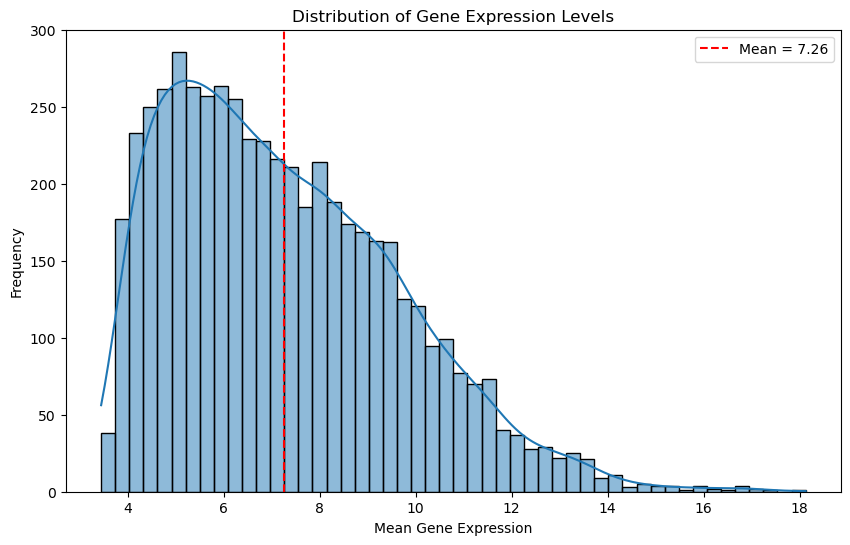

In [26]:
# Plot the distribution of gene expression levels 

# Calculate the mean expression level for each gene
gene_means = df_renamed.mean(axis=0)

# Plot the distribution of gene expression levels
plt.figure(figsize=(10, 6))
sns.histplot(gene_means, bins=50, kde=True)
plt.xlabel('Mean Gene Expression')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Expression Levels')

# mean of the gene means
threshold = gene_means.mean()
plt.axvline(threshold, color='red', linestyle='--', label=f'Mean = {threshold:.2f}')
plt.legend()

plt.show()

Let's see the most extreme cases to get a better idea what is in the data.

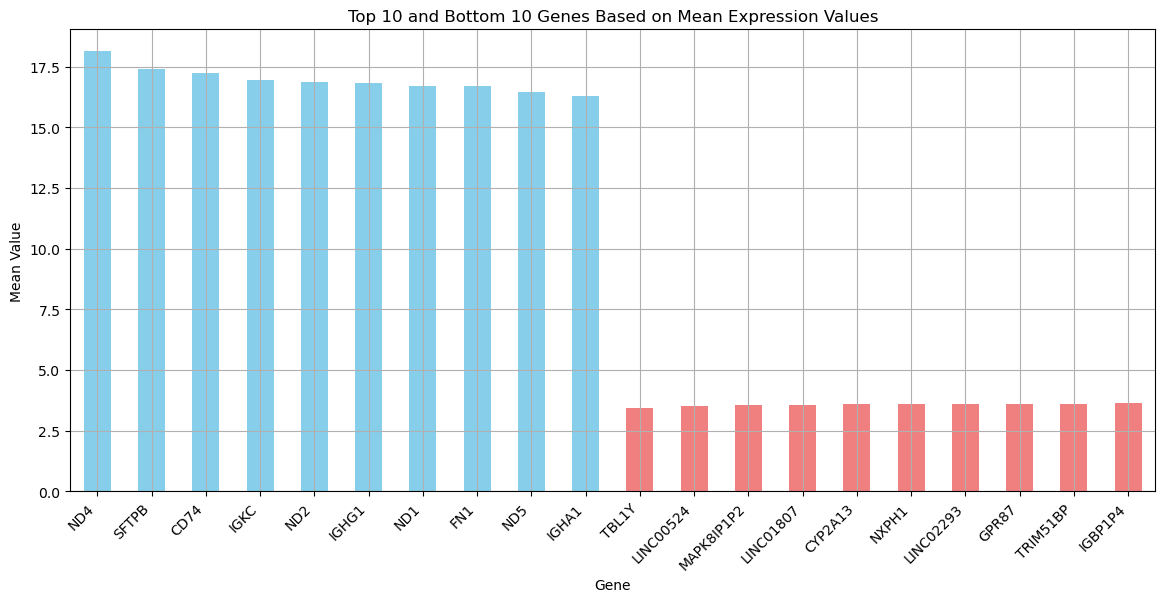

In [28]:
# Sort and get the top 10 and bottom 10 columns based on their mean values

top_10_columns = gene_means.sort_values(ascending=False).head(10)
bottom_10_columns = gene_means.sort_values(ascending=True).head(10)

# Combine top 10 and bottom 10 columns into one DataFrame
combined = pd.concat([top_10_columns, bottom_10_columns])

# Plot the results
plt.figure(figsize=(14, 6))
combined.plot(kind='bar', color=['skyblue' if i < 10 else 'lightcoral' for i in range(20)])
plt.title('Top 10 and Bottom 10 Genes Based on Mean Expression Values')
plt.ylabel('Mean Value')
plt.xlabel('Gene')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

## Further Data Investigation

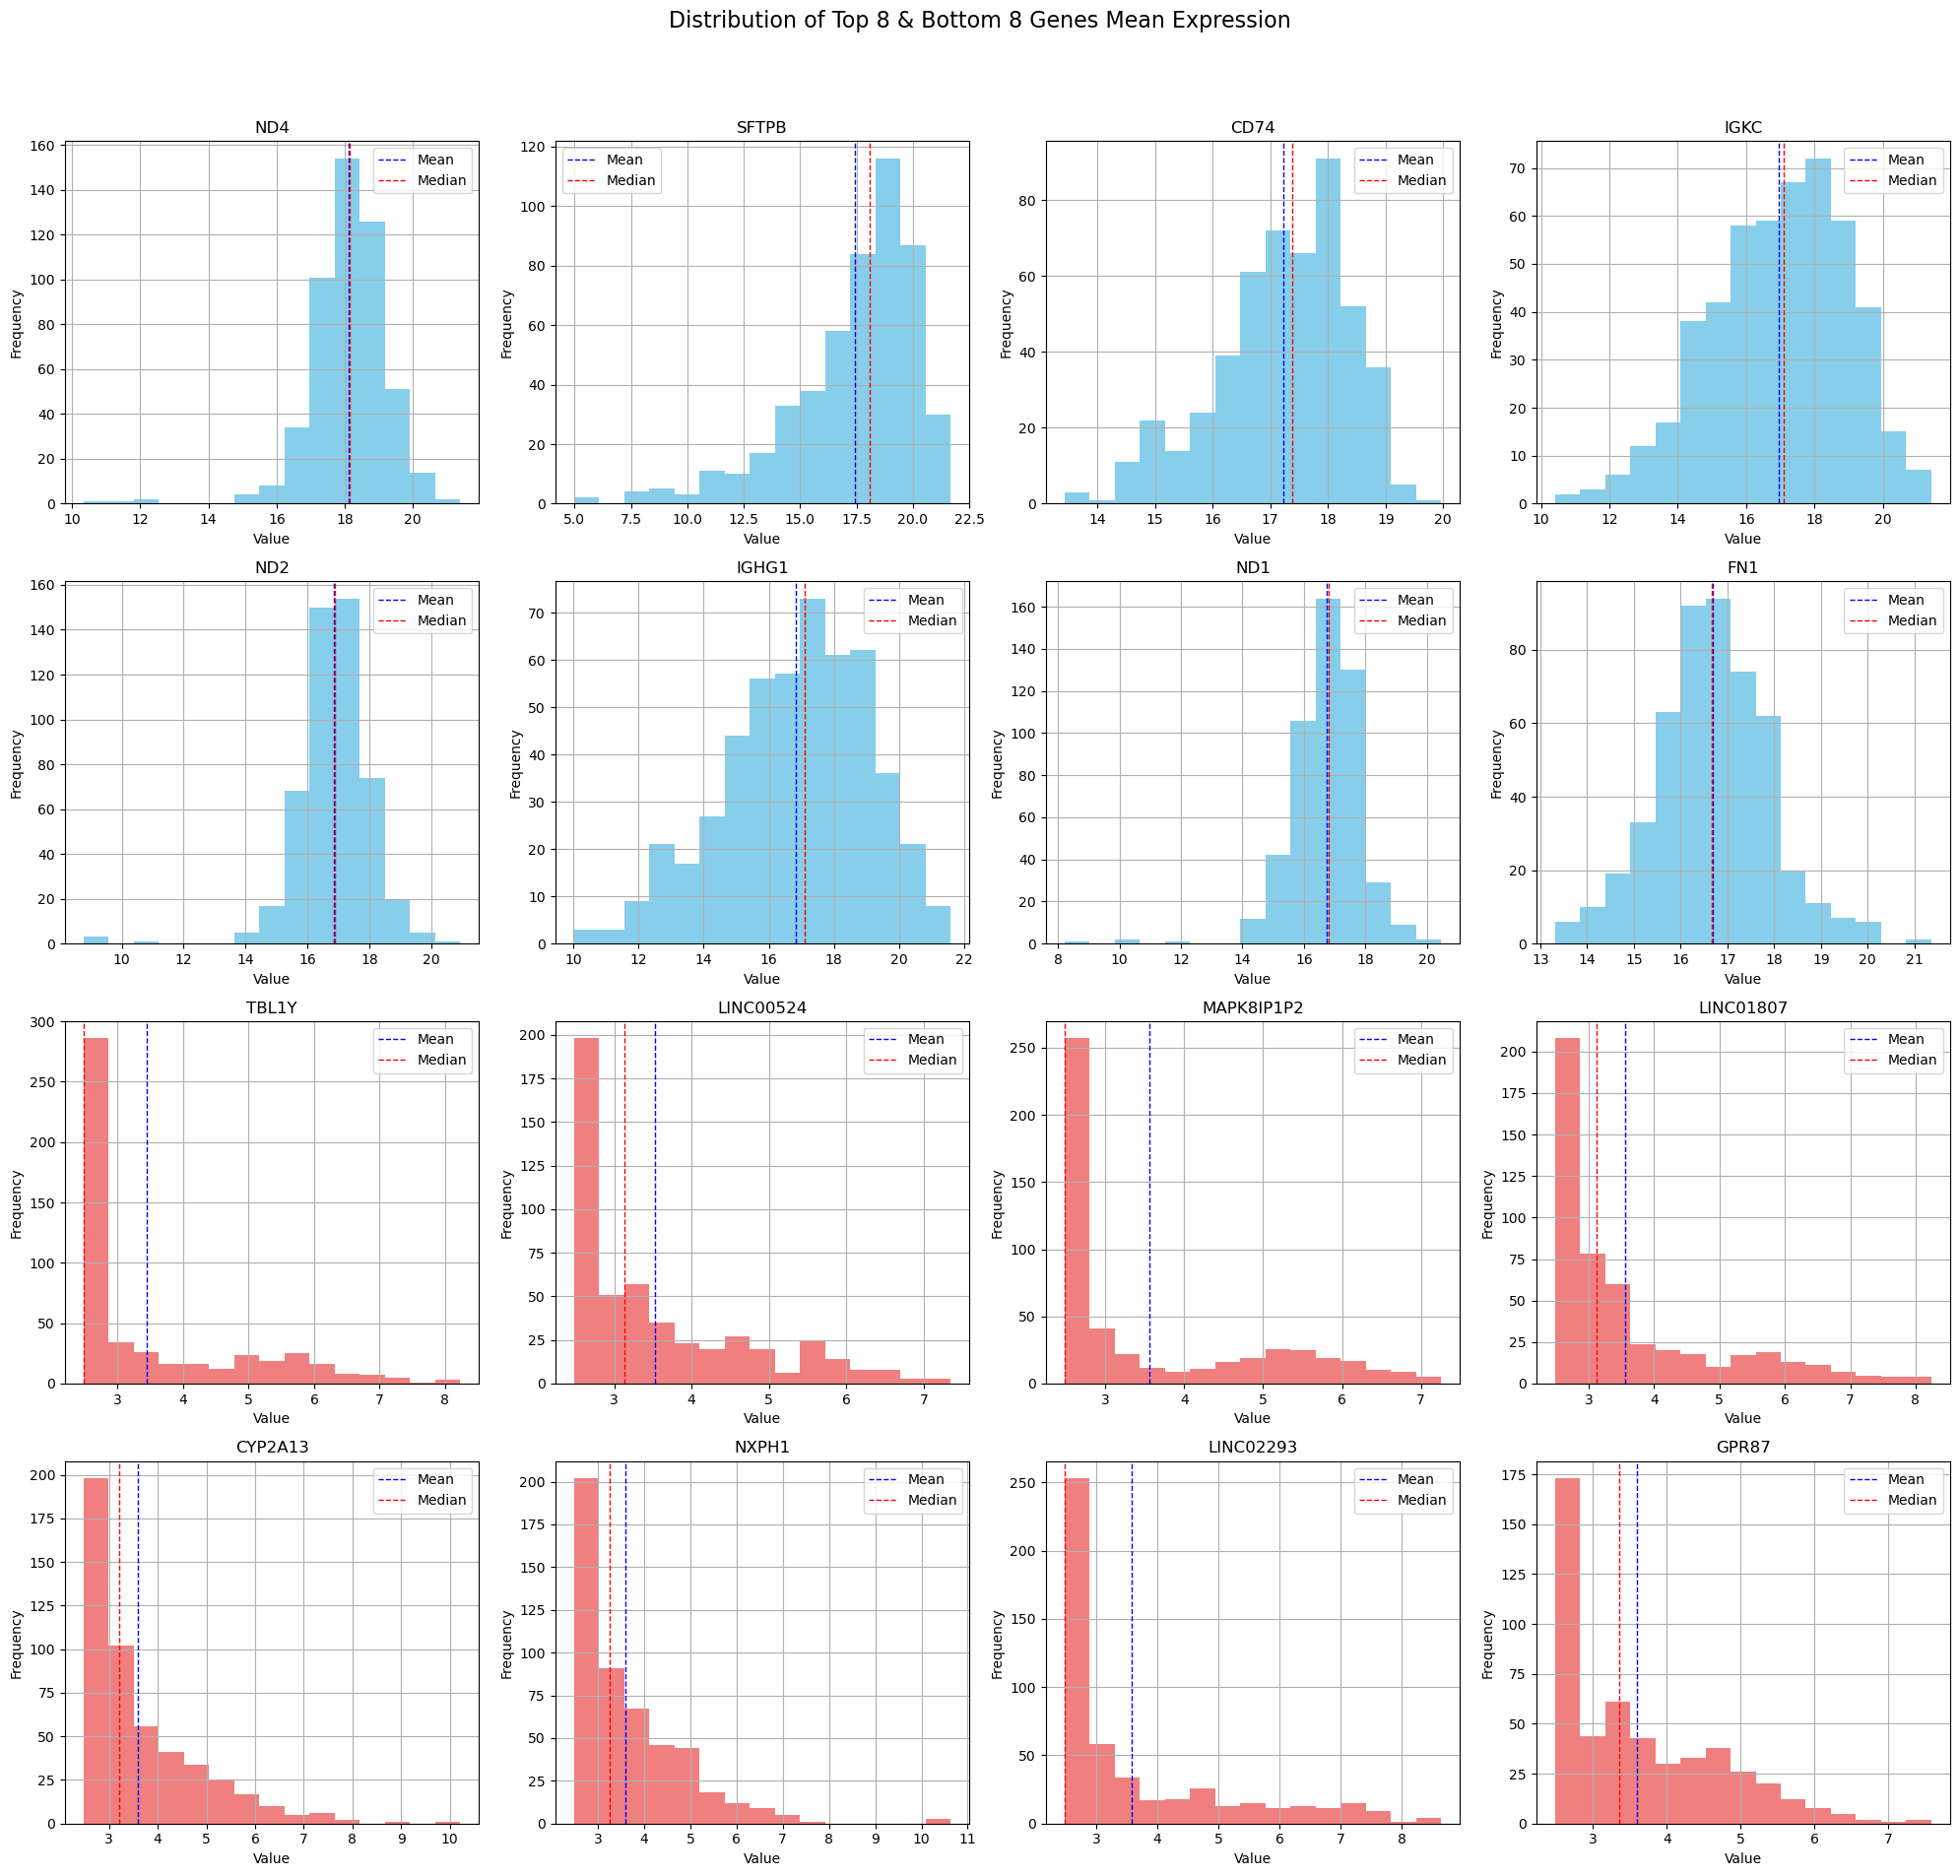

In [29]:
# Select numerical columns
numerical_columns = df_renamed.select_dtypes(include=['float64', 'int64'])

# Calculate the mean of each column for the numerical columns only
means = numerical_columns.mean()

# Get the top 8 and bottom 8 columns based on mean values
top_8_columns = means.nlargest(8).index.tolist()
bottom_8_columns = means.nsmallest(8).index.tolist()

# Combine top 8 and bottom 8 columns for plotting
columns_to_plot = top_8_columns + bottom_8_columns

# Filter the numerical columns to only include those to plot
filtered_numerical_columns = numerical_columns[columns_to_plot]

# Calculate the number of rows needed for subplots based on the number of selected columns
num_plots = len(filtered_numerical_columns.columns)
num_rows = (num_plots // 4) + (num_plots % 4 > 0)  # Ensure there is an extra row if there are leftovers

# Plot histograms for each selected numerical column
fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))  # Adjust width and height as needed
fig.suptitle('Distribution of Top 8 & Bottom 8 Genes Mean Expression', fontsize=16)

for i, col in enumerate(filtered_numerical_columns.columns):
    ax = axes.flatten()[i]
    filtered_numerical_columns[col].hist(bins=15, ax=ax, color='skyblue' if i < 8 else 'lightcoral')
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Adding mean and median lines
    mean_val = filtered_numerical_columns[col].mean()
    median_val = filtered_numerical_columns[col].median()
    ax.axvline(mean_val, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(median_val, color='red', linestyle='dashed', linewidth=1)
    ax.legend({'Mean': mean_val, 'Median': median_val})

# Hide any unused axes if the number of plots isn't a perfect multiple of 4
if num_plots % 4:
    for ax in axes.flatten()[num_plots:]:
        ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

# 4. Correlation Matrix Calculation

In order to create a biological network, we have to calculate the correlation matrix of the gene expression data.\
The correlation matrix shows how strongly pairs of genes are related. \
The assumption is that if genes are correlated, then this means they influence each others behaviour.  

Using the correlation matrix, we can build a gene expression network. In this network, genes are connected based on significant correlations.
  

- nodes: genes  
- edges: highly correlated genes (above a given threshold)
- edge-weights: correlation values

There are a few correlation metrics one could consider:
- [Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)  
  - O(n^2) complexity, fast for large datasets
- [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
  -  O(n^2 log n) complexity, relatively fast but can be slower than Pearson
- [Absolute biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation)
  - Robust but slower than Pearson and Spearman, suitable for datasets with outliers


In [30]:
# function to calculate absolute biweight midcorrelation 
def abs_bicorr(data):
    # Select only numeric data
    data = data._get_numeric_data()
    cols = data.columns
    idx = cols.copy()
    mat = data.to_numpy(dtype=float, na_value=np.nan, copy=False)
    mat = mat.T

    K = len(cols)
    correl = np.empty((K, K), dtype=np.float32)

    # Calculate biweight midcovariance
    bicorr = astropy.stats.biweight_midcovariance(mat, modify_sample_size=True)

    for i in range(K):
        for j in range(K):
            if i == j:
                correl[i, j] = 1.0
            else:
                denominator = np.sqrt(bicorr[i, i] * bicorr[j, j])
                if denominator != 0:
                    correl[i, j] = bicorr[i, j] / denominator
                else:
                    correl[i, j] = 0  # Or handle it in another appropriate way

    return pd.DataFrame(data=np.abs(correl), index=idx, columns=cols, dtype=np.float32)

Consider loading in precomputed correlation matrices and skipping the cell after.

In [31]:
# Load the entire dictionary of correlation matrices from a pickle file
with open(os.path.join(intermediate_data_dir,"correlation_matrices.pkl"), 'rb') as f:
    correlation_matrices = pickle.load(f)

# Verify the loaded data
print(correlation_matrices.keys())

dict_keys(['pearson', 'spearman', 'biweight_midcorrelation'])


In [104]:
# # Dictionary to store different correlation matrices
# correlation_matrices = {}

# # Pearson correlation - O(n^2) complexity, fast for large datasets
# correlation_matrices['pearson'] = df_renamed.corr(method='pearson')

# # Spearman rank correlation -  O(n^2 log n) complexity, relatively fast but can be slower than Pearson
# correlation_matrices['spearman'] = df_renamed.corr(method='spearman')

# # Biweight midcorrelation -  Robust but slower than Pearson and Spearman, suitable for datasets with outliers
# correlation_matrices['biweight_midcorrelation'] = abs_bicorr(df_renamed)

# # Print the keys of the correlation matrices to verify
# print("Correlation matrices calculated:")
# print(correlation_matrices.keys())


# # Save the entire dictionary of correlation matrices as a pickle file
# with open(os.path.join(intermediate_data_dir,"correlation_matrices.pkl"), 'wb') as f:
#     pickle.dump(correlation_matrices, f)


In [32]:
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_correlation_matrices(correlation_matrices):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust to 1 row and 3 columns
    axes = axes.flatten()
    
    for i, (key, matrix) in enumerate(correlation_matrices.items()):
        # Perform hierarchical clustering
        Z = linkage(matrix, method='average')  # You can use other methods like 'single', 'complete', etc.
        idx = leaves_list(Z)
        
        # Reorder matrix
        ordered_matrix = matrix.iloc[idx, :].iloc[:, idx]
        
        # Plot heatmap
        sns.heatmap(ordered_matrix, ax=axes[i], cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=False)
        axes[i].set_title(f'{key.capitalize()} Correlation Matrix')
        
        # Set square aspect ratio
        axes[i].set_aspect('equal', adjustable='box')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


We are not going to run this script, because it take a while.

In [105]:
# The correlation_matrices variable is a dictionary of correlation matrices
# plot_correlation_matrices(correlation_matrices)

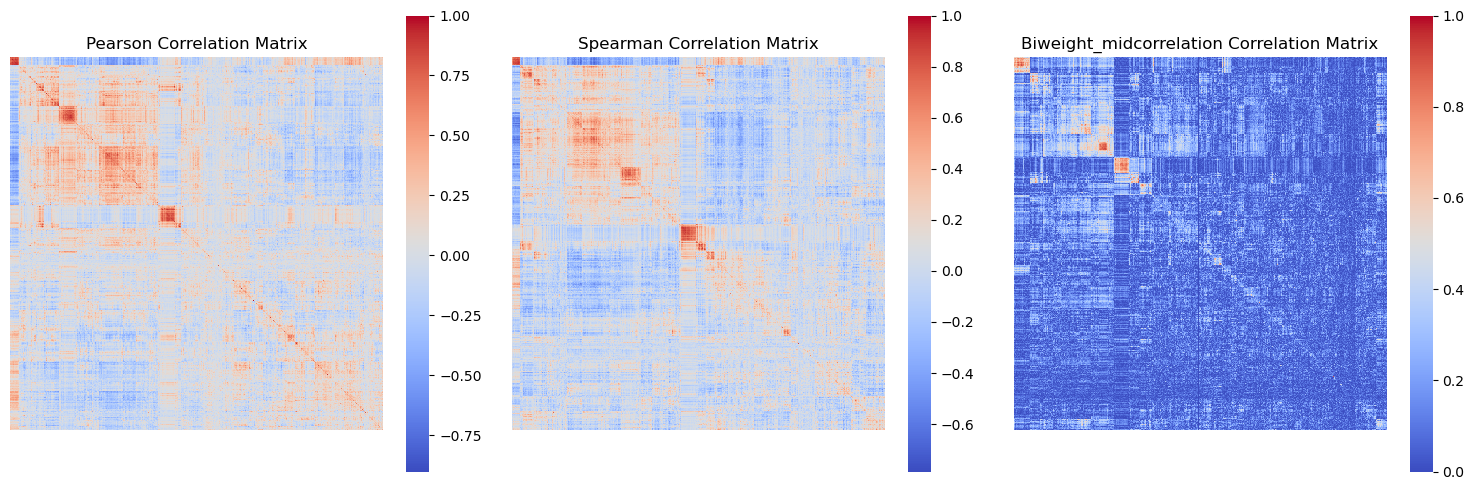

In [41]:
# Display the image of the correlation matrices
display(Image(filename=os.path.join(intermediate_data_dir,
                                    "figures",
                                    "correlation_matrices_figure.png")))

# 5. Graph Construction from Correlation Matrices

In this stage we are leaving behind the raw data, and we are going to start to work with network objects.  
We are using the [NetworkX](https://networkx.org/documentation/stable/reference/index.html) library for this. 

We are going to run a function `create_graph_from_correlation`.  

The function starts by creating an empty graph G. Then iterates through the columns of the correlation matrix and adds each column name as a node in the graph. This means each gene (or feature) in your dataset becomes a node in the graph.

The function iterates over the upper triangle of the correlation matrix (excluding the diagonal) to avoid redundancy and self-loops.

For each pair of nodes (i, j), it checks if the absolute value of the correlation coefficient between them is greater than or equal to the specified threshold.
If the condition is met, an edge is added between the nodes i and j with the correlation coefficient as the weight of the edge. This signifies a strong correlation (positive or negative) between the two nodes.

In [38]:
def create_graph_from_correlation(correlation_matrix, threshold=0.8):
    """
    Creates a graph from a correlation matrix using a specified threshold.

    Parameters:
    correlation_matrix (pd.DataFrame): DataFrame containing the correlation matrix.
    threshold (float): Threshold for including edges based on correlation value.

    Returns:
    G (nx.Graph): Graph created from the correlation matrix.
    """
    G = nx.Graph()

    # Add nodes
    for node in correlation_matrix.columns:
        G.add_node(node)

    # Add edges with weights above the threshold
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if i != j:  # Ignore the diagonal elements
                weight = correlation_matrix.iloc[i, j]
                if abs(weight) >= threshold:
                    G.add_edge(correlation_matrix.index[i], correlation_matrix.columns[j], weight=weight)

    return G

In [108]:
## correlation_matrices is a dictionary containing correlation matrices
# pearson_graph = create_graph_from_correlation(correlation_matrices['pearson'], threshold=0.8)

In [17]:
# nx.write_gml(pearson_graph, os.path.join(data_dir,'gene_coexpression_network_pearson.gml'))
pearson_graph = nx.read_gml(os.path.join(intermediate_data_dir,'gene_coexpression_network_pearson.gml'))


Now let's go through a few useful NetworkX functions and create a `print_graph_info()` function.

In [113]:
def print_graph_info(G):
    """
    Prints basic information about the graph.
    
    Parameters:
    G (nx.Graph): The NetworkX graph.
    """
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print("Sample nodes:", list(G.nodes)[:10])  # Print first 10 nodes as a sample
    print("Sample edges:", list(G.edges(data=True))[:10])  # Print first 10 edges as a sample
    
    info_str = "Graph type: "
    is_directed = G.is_directed()
    if is_directed:
        info_str += "directed"
    else:
        info_str += "undirected"
    print(info_str)

    # Check for self-loops
    self_loops = list(nx.selfloop_edges(G))
    if self_loops:
        print(f"Number of self-loops: {len(self_loops)}")
        print("Self-loops:", self_loops)
    else:
        print("No self-loops in the graph.")

    # density of the graph
    density = nx.density(G)
    print(f"Graph density: {density}")

    # Find and print the number of connected components
    num_connected_components = nx.number_connected_components(G)
    print(f"Number of connected components: {num_connected_components}")

    # Calculate and print the clustering coefficient of the graph
    clustering_coeff = nx.average_clustering(G)
    print(f"Average clustering coefficient: {clustering_coeff}")

In [114]:
print_graph_info(pearson_graph)

Number of nodes: 5338
Number of edges: 13449
Sample nodes: ['A2M', 'A2ML1', 'A4GALT', 'AACSP1', 'AADAC', 'AADACP1', 'AARD', 'AASS', 'AATBC', 'AATK']
Sample edges: [('A2M', 'ABCA8', {'weight': 0.8308274641648915}), ('A2M', 'ADAMTS8', {'weight': 0.8036704002698273}), ('A2M', 'AOC3', {'weight': 0.8767411078325781}), ('A2M', 'C7', {'weight': 0.8013688242083488}), ('A2M', 'INMT', {'weight': 0.8117391230502314}), ('A2M', 'ITGA8', {'weight': 0.8724141478160804}), ('A2M', 'MFAP4', {'weight': 0.8444697225886688}), ('A2M', 'PKNOX2', {'weight': 0.8062841461653377}), ('A2M', 'SCN7A', {'weight': 0.8382334505662205}), ('A2M', 'SLIT2', {'weight': 0.8041515706739126})]
Graph type: undirected
No self-loops in the graph.
Graph density: 0.0009441569992192751
Number of connected components: 4392
Average clustering coefficient: 0.1045798392696385


In [64]:
# biweight_graph = create_graph_from_correlation(correlation_matrices['biweight_midcorrelation'], threshold=0.8)

In [115]:
# Function to visualize the graph
def visualize_graph(G, title='Gene Co-expression Network'):
    """
    Visualizes the graph using Matplotlib and NetworkX.

    Parameters:
    G (nx.Graph): Graph to visualize.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)  # k controls the distance between nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.5)
    plt.title(title)
    plt.show()

In [116]:
# # Visualize the graph
# visualize_graph(pearson_graph, title='Pearson Correlation Network (Threshold = 0.8)')

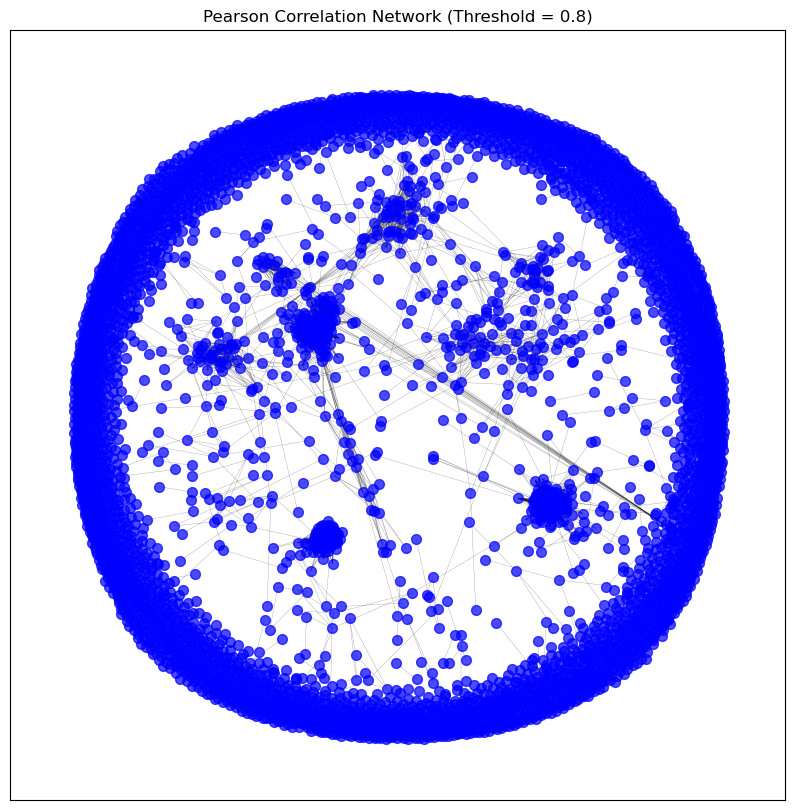

In [42]:
# Display the image of the full graph
display(Image(filename=os.path.join(intermediate_data_dir,
                                    "figures",
                                    "full_gene_coexpression_network.png")))

In [66]:
# visualize_graph(biweight_graph, title='Biweight MidCorrelation Network (Threshold = 0.8)')

# 6. Network Cleaning

Now that we have created the gene co-expression networks, we can further clean and analyse the network.

We can still use functions of NetworkX specifically made for this.

In [117]:
def clean_graph(G, degree_threshold=1, keep_largest_component=True):
    """
    Cleans the graph by performing several cleaning steps:
    - Removes unconnected nodes (isolates)
    - Removes self-loops
    - Removes nodes with a degree below a specified threshold
    - Keeps only the largest connected component (optional)

    Parameters:
    G (nx.Graph): The NetworkX graph to clean.
    degree_threshold (int): Minimum degree for nodes to keep.
    keep_largest_component (bool): Whether to keep only the largest connected component.

    Returns:
    G (nx.Graph): Cleaned graph.
    """
    G = G.copy()  # Work on a copy of the graph to avoid modifying the original graph

    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Remove nodes with no edges (isolates)
    G.remove_nodes_from(list(nx.isolates(G)))

    # Remove nodes with degree below the threshold
    low_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree < degree_threshold]
    G.remove_nodes_from(low_degree_nodes)

    # Keep only the largest connected component
    if keep_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G

In [118]:
# Clean the graph by removing unconnected nodes
pearson_graph_cleaned = clean_graph(pearson_graph,
                                    degree_threshold=0,
                                    keep_largest_component=False)

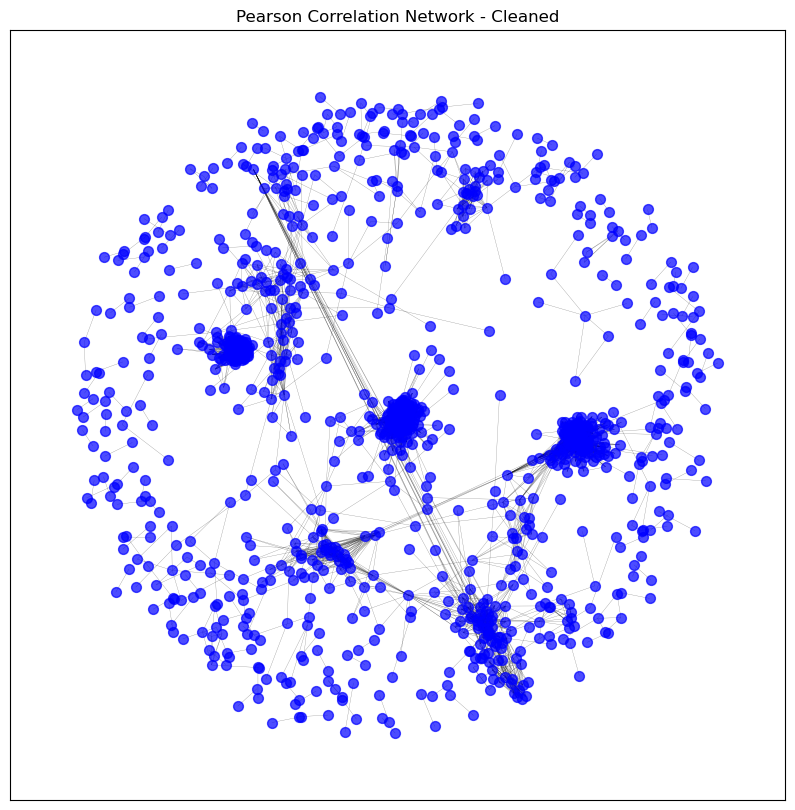

In [119]:
visualize_graph(pearson_graph_cleaned, title='Pearson Correlation Network - Cleaned')

In [120]:
print_graph_info(pearson_graph_cleaned)

Number of nodes: 1114
Number of edges: 13449
Sample nodes: ['A2M', 'ABCA8', 'ABCC9', 'ACKR1', 'ACKR2', 'ACOXL', 'ACOXL-AS1', 'ACTG2', 'ADAM12', 'ADAMTS12']
Sample edges: [('A2M', 'ABCA8', {'weight': 0.8308274641648915}), ('A2M', 'ADAMTS8', {'weight': 0.8036704002698273}), ('A2M', 'AOC3', {'weight': 0.8767411078325781}), ('A2M', 'C7', {'weight': 0.8013688242083488}), ('A2M', 'INMT', {'weight': 0.8117391230502314}), ('A2M', 'ITGA8', {'weight': 0.8724141478160804}), ('A2M', 'MFAP4', {'weight': 0.8444697225886688}), ('A2M', 'PKNOX2', {'weight': 0.8062841461653377}), ('A2M', 'SCN7A', {'weight': 0.8382334505662205}), ('A2M', 'SLIT2', {'weight': 0.8041515706739126})]
Graph type: undirected
No self-loops in the graph.
Graph density: 0.021693999912894935
Number of connected components: 168
Average clustering coefficient: 0.5011195529814455


In [130]:
# Clean the graph by removing unconnected nodes
pearson_graph_pruned = clean_graph(pearson_graph,
                                    degree_threshold=1,
                                    keep_largest_component=True)

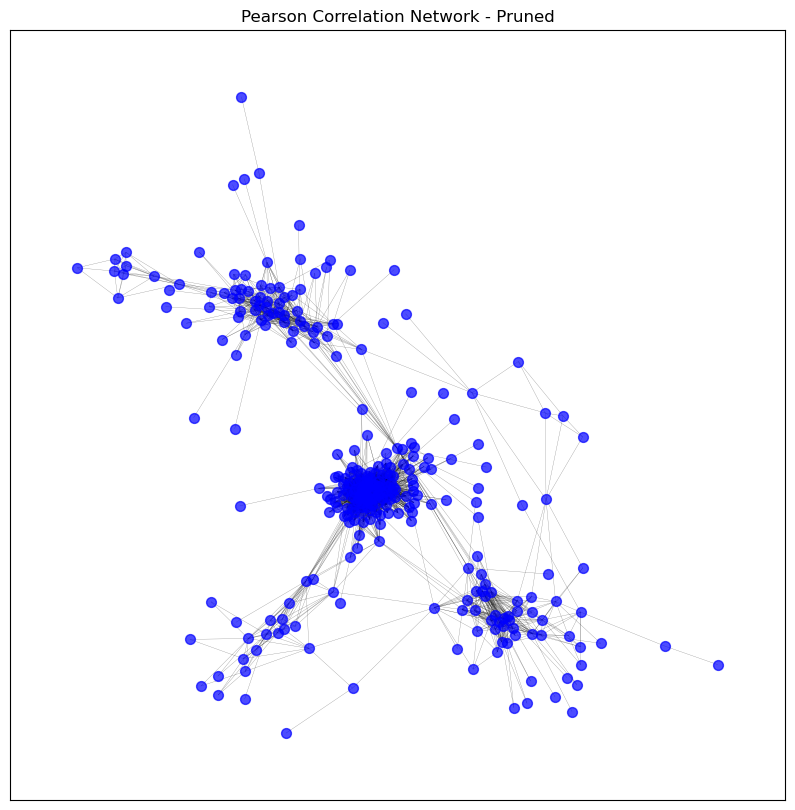

In [131]:
visualize_graph(pearson_graph_pruned, title='Pearson Correlation Network - Pruned')

In [ ]:
# save the graph as a GML file for future use
#nx.write_gml(pearson_graph_pruned, os.path.join(intermediate_data_dir,"gene_coexpression_network.gml"))

In [133]:
print_graph_info(pearson_graph_pruned)

Number of nodes: 305
Number of edges: 4033
Sample nodes: ['SPN', 'SCML4', 'IL2RG', 'CCL23', 'TLR7', 'FAM30A', 'LILRB4', 'IGKV4-1', 'CXCR6', 'FCGR1A']
Sample edges: [('SPN', 'CD300LF', {'weight': 0.8054549326650037}), ('SPN', 'CYBB', {'weight': 0.8225847332114441}), ('SPN', 'DOK2', {'weight': 0.8694303780879173}), ('SPN', 'FGR', {'weight': 0.8239102785759777}), ('SPN', 'HCK', {'weight': 0.8015665561321501}), ('SPN', 'JAML', {'weight': 0.9034237904179987}), ('SPN', 'MAP3K5-AS2', {'weight': 0.8098711495923998}), ('SPN', 'MNDA', {'weight': 0.8269221117933395}), ('SPN', 'P2RY13', {'weight': 0.823261045280138}), ('SPN', 'PRAM1', {'weight': 0.8016230886119241})]
Graph type: undirected
No self-loops in the graph.
Graph density: 0.08699309749784297
Number of connected components: 1
Average clustering coefficient: 0.6766781614263463


In [132]:
def plot_degree_distribution(G):
    """
    Plots the degree distribution of the graph using Seaborn.
    
    Parameters:
    G (nx.Graph): The NetworkX graph.
    """
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(10, 6))
    sns.histplot(degrees, bins=30, kde=False, edgecolor='black')
    plt.title('Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()


Number of nodes: 305
Number of edges: 4033
Sample nodes: ['SPN', 'SCML4', 'IL2RG', 'CCL23', 'TLR7', 'FAM30A', 'LILRB4', 'IGKV4-1', 'CXCR6', 'FCGR1A']
Sample edges: [('SPN', 'CD300LF', {'weight': 0.8054549326650037}), ('SPN', 'CYBB', {'weight': 0.8225847332114441}), ('SPN', 'DOK2', {'weight': 0.8694303780879173}), ('SPN', 'FGR', {'weight': 0.8239102785759777}), ('SPN', 'HCK', {'weight': 0.8015665561321501}), ('SPN', 'JAML', {'weight': 0.9034237904179987}), ('SPN', 'MAP3K5-AS2', {'weight': 0.8098711495923998}), ('SPN', 'MNDA', {'weight': 0.8269221117933395}), ('SPN', 'P2RY13', {'weight': 0.823261045280138}), ('SPN', 'PRAM1', {'weight': 0.8016230886119241})]
Graph type: undirected
No self-loops in the graph.
Graph density: 0.08699309749784297
Number of connected components: 1
Average clustering coefficient: 0.6766781614263463


/home/skamp/.conda/envs/ismbenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


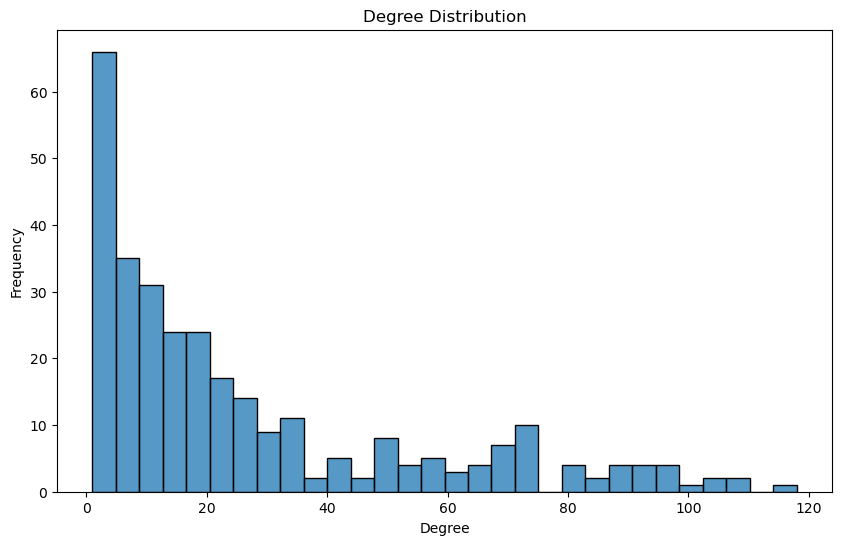

In [134]:
print_graph_info(pearson_graph_pruned)
plot_degree_distribution(pearson_graph_pruned)

In [135]:
def visualize_edge_weight_distribution(G):
    """
    Visualizes the distribution of edge weights using a histogram and KDE plot.

    Parameters:
    edge_weights (list): List of edge weights.
    """
    plt.figure(figsize=(10, 6))
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    # Histogram
    sns.histplot(edge_weights, bins=30, kde=False)
    
    plt.title('Distribution of Edge Weights')
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.show()

/home/skamp/.conda/envs/ismbenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


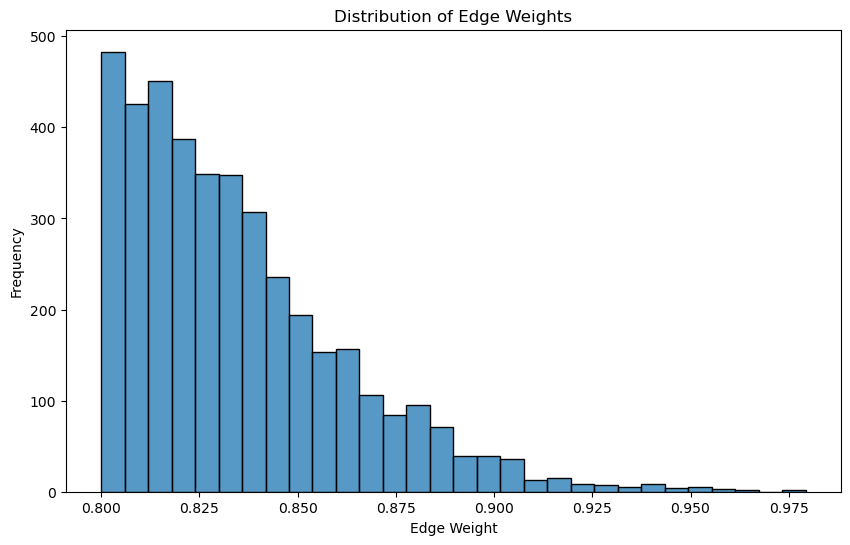

In [80]:
# Visualize the distribution of edge weights
visualize_edge_weight_distribution(pearson_graph_pruned)

# 7. Sparsification methods

With sparsification we aim to reduce the number of edges in a network while preserving important structural properties.

- Edge Sampling: Randomly removes a fraction of edges.
- Thresholding: Removes edges with weights below a certain threshold.
- Degree-based Sparsification

In [43]:
def threshold_sparsification(graph, threshold):
    """
    Sparsifies the graph by removing edges below the specified weight threshold.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    threshold (float): The weight threshold.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    sparsified_graph = nx.Graph()
    sparsified_graph.add_nodes_from(graph_copy.nodes(data=True))
    sparsified_graph.add_edges_from((u, v, d) for u, v, d in graph_copy.edges(data=True) if d.get('weight', 0) >= threshold)
    return sparsified_graph

def top_percentage_sparsification(graph, top_percentage):
    """
    Sparsifies the graph by keeping the top percentage of edges by weight.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    top_percentage (float): The percentage of top-weight edges to keep.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    sorted_edges = sorted(graph_copy.edges(data=True), key=lambda x: x[2].get('weight', 0), reverse=True)
    top_edges_count = max(1, int(len(sorted_edges) * (top_percentage / 100)))
    sparsified_graph = nx.Graph()
    sparsified_graph.add_nodes_from(graph_copy.nodes(data=True))
    sparsified_graph.add_edges_from(sorted_edges[:top_edges_count])
    return sparsified_graph


def remove_by_degree(graph, min_degree):
    """
    Sparsifies the graph by removing nodes with degree below the specified threshold.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    min_degree (int): The minimum degree threshold.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    nodes_to_remove = [node for node, degree in dict(graph_copy.degree()).items() if degree < min_degree]
    
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

def knn_sparsification(graph, k):
    """
    Sparsifies the graph by keeping only the top-k edges with the highest weights for each node.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    k (int): The number of nearest neighbors to keep for each node.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    sparsified_graph = nx.Graph()
    sparsified_graph.add_nodes_from(graph_copy.nodes(data=True))
    
    for node in graph_copy.nodes():
        edges = sorted(graph_copy.edges(node, data=True), key=lambda x: x[2].get('weight', 0), reverse=True)
        sparsified_graph.add_edges_from(edges[:k])
    
    return sparsified_graph


def spanning_tree_sparsification(graph):
    """
    Sparsifies the graph by creating a minimum spanning tree.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.

    Returns:
    nx.Graph: The sparsified graph.
    """
    graph_copy = graph.copy()
    return nx.minimum_spanning_tree(graph_copy, weight='weight')



In [81]:
def analyze_and_plot_density(graph):
    """
    Calculates and plots the density of the graph for a predefined series of thresholds.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.

    Returns:
    densities (list of float): Densities of the graph at each threshold.
    """
    thresholds = [0.7 + i * 0.01 for i in range(31)]
    densities = []

    for threshold in thresholds:
        filtered_edges = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] > threshold]
        temp_graph = nx.Graph()
        temp_graph.add_edges_from(filtered_edges)
        densities.append(nx.density(temp_graph))

    # Plot the densities
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, densities, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Density')
    plt.title('Density vs. Threshold')
    plt.grid(True)
    plt.show()

    return densities

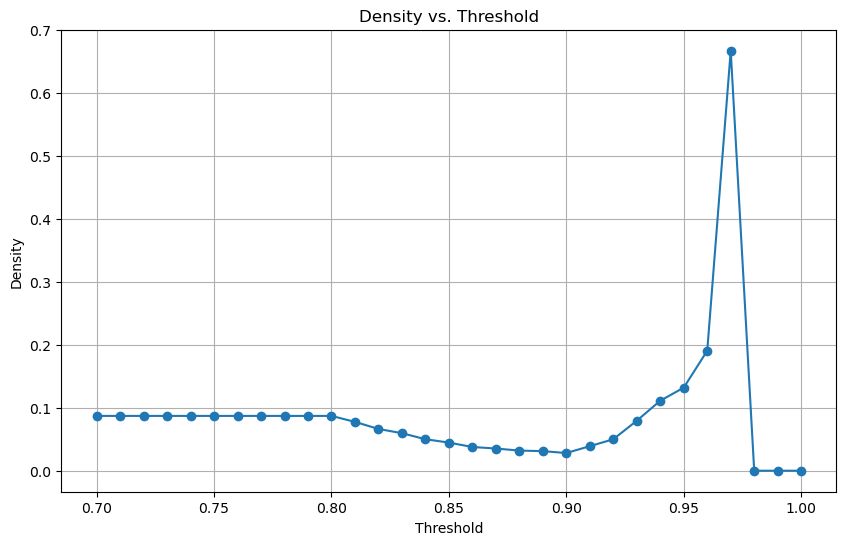

In [136]:
densities = analyze_and_plot_density(pearson_graph_pruned)

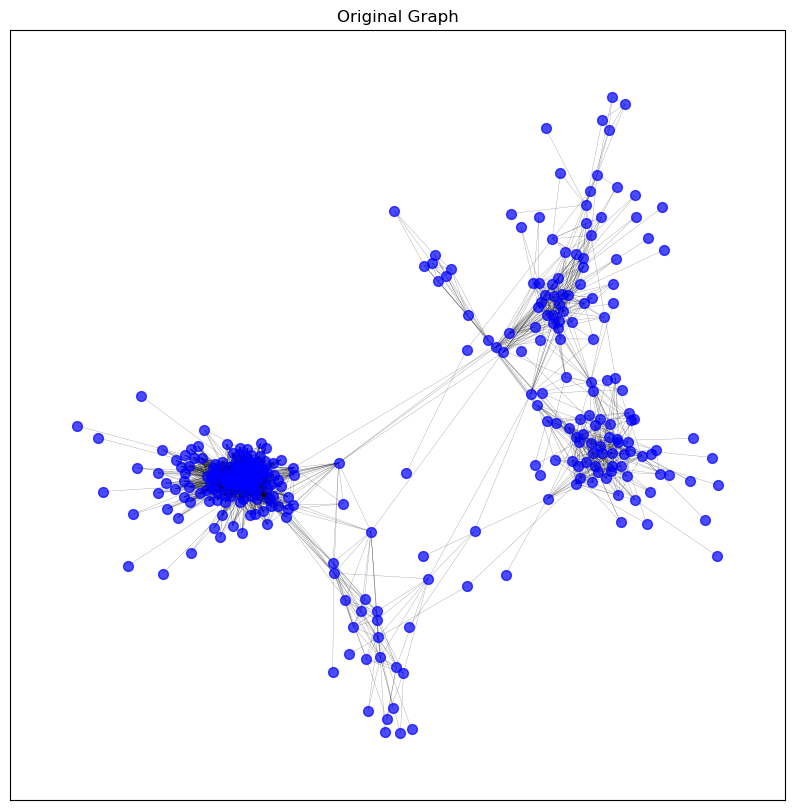

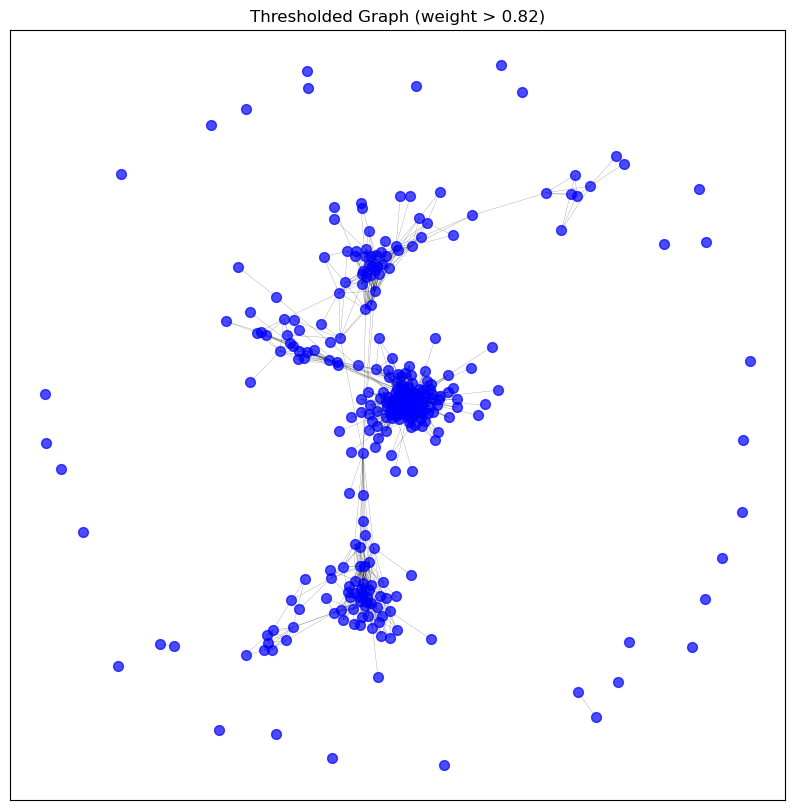

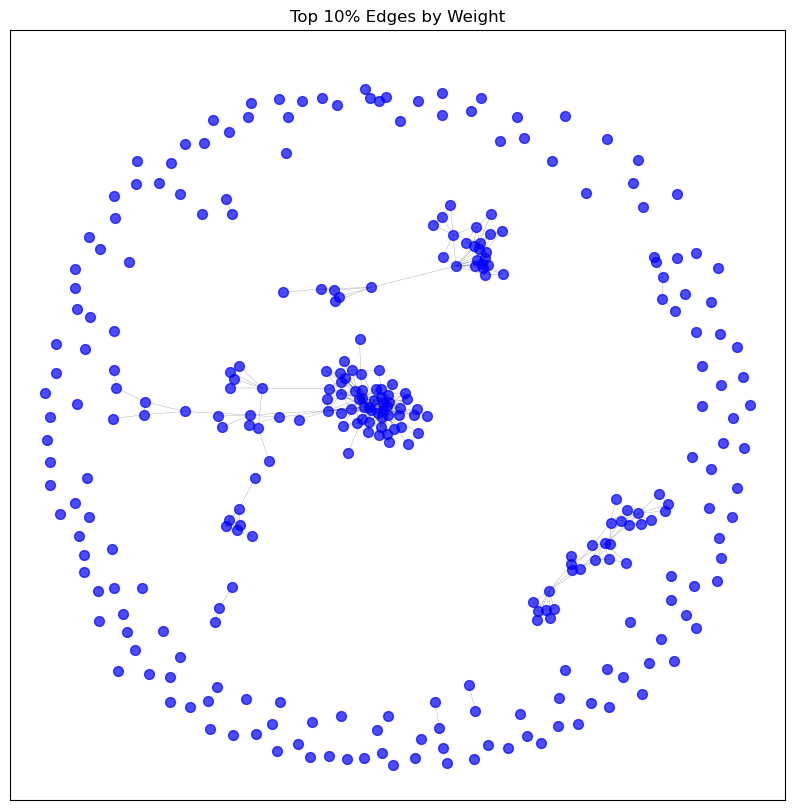

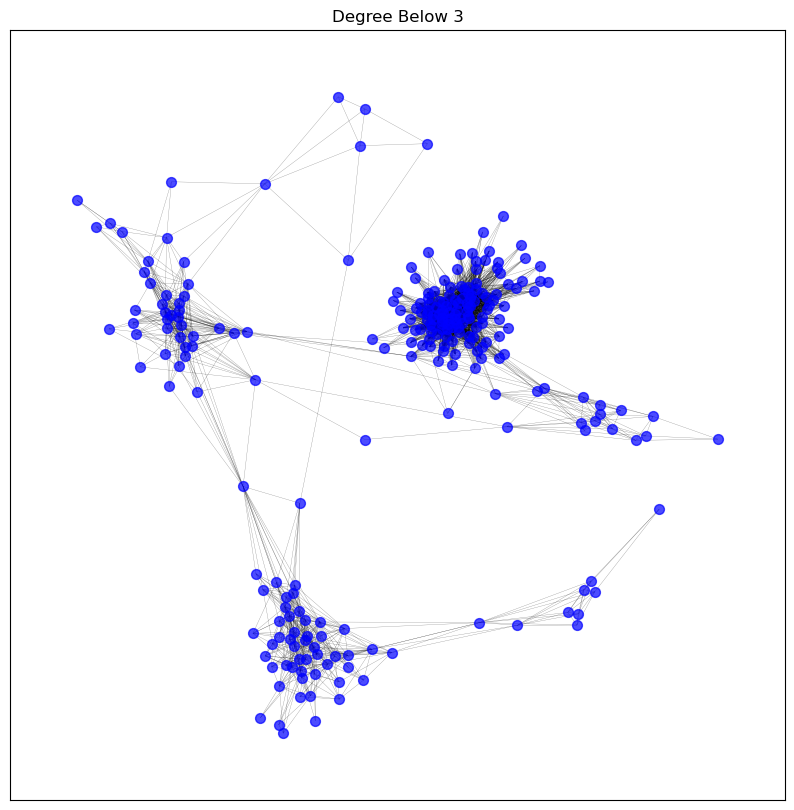

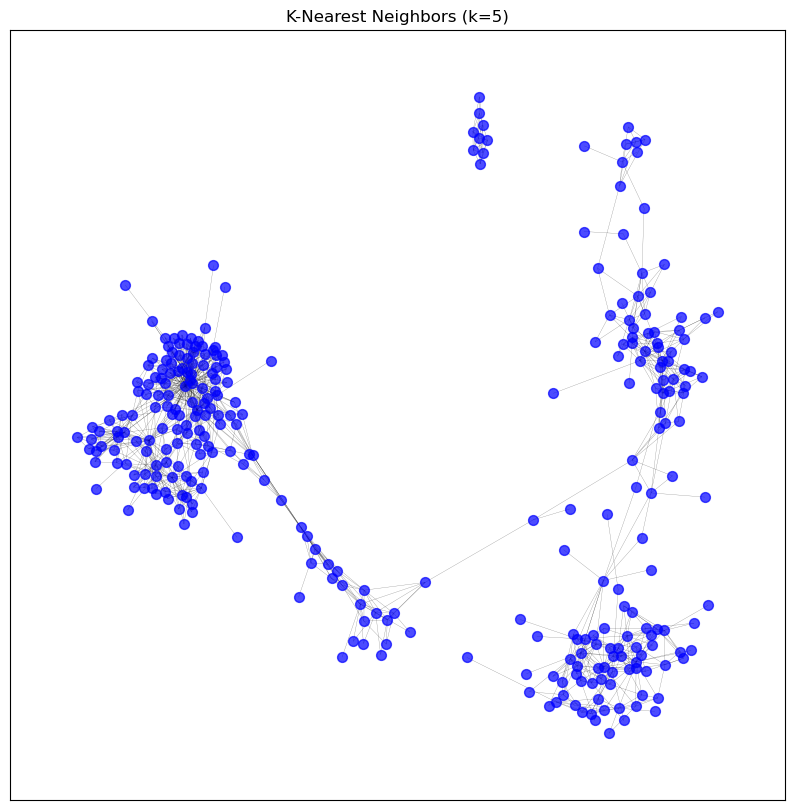

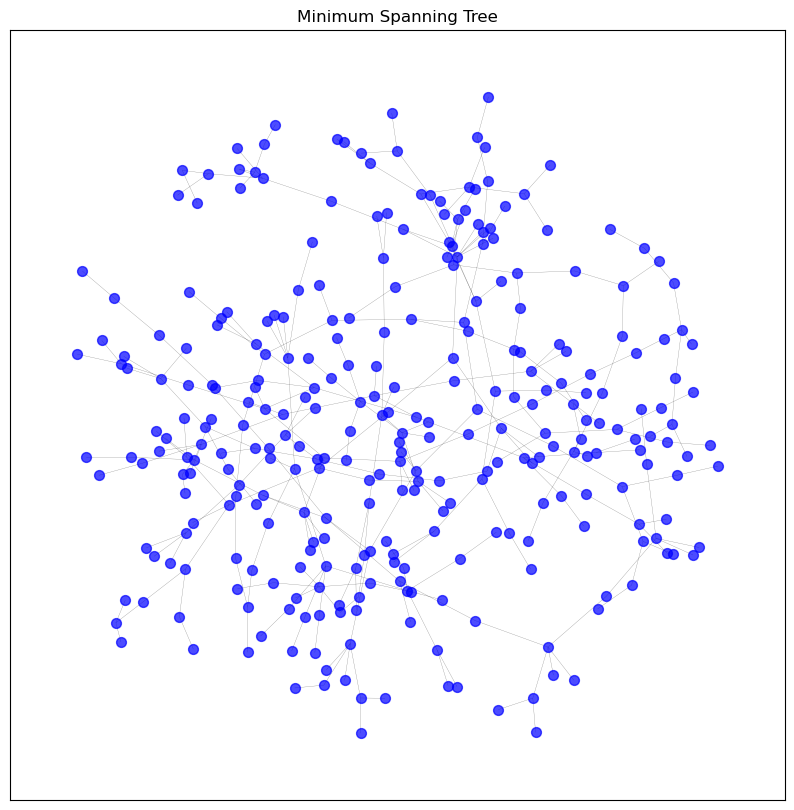

In [143]:
# Initialize a dictionary to store graphs
graphs = {}
graphs['original'] = pearson_graph_pruned.copy()  # Store the original graph

# Apply sparsification methods
graphs['threshold'] = threshold_sparsification(graphs['original'], threshold=0.82)
graphs['top_10_percent'] = top_percentage_sparsification(graphs['original'], top_percentage=10)
graphs['degree_below_3'] = remove_by_degree(graphs['original'], min_degree=3)
graphs['knn_5'] = knn_sparsification(graphs['original'], k=5)
graphs['spanning_tree'] = spanning_tree_sparsification(graphs['original'])


# Example visualization
visualize_graph(graphs['original'], 'Original Graph')
visualize_graph(graphs['threshold'], 'Thresholded Graph (weight > 0.82)')
visualize_graph(graphs['top_10_percent'], 'Top 10% Edges by Weight')
visualize_graph(graphs['degree_below_3'], 'Degree Below 3')
visualize_graph(graphs['knn_5'], 'K-Nearest Neighbors (k=5)')
visualize_graph(graphs['spanning_tree'], 'Minimum Spanning Tree')


In [144]:
print_graph_info(graphs['knn_5'])


Number of nodes: 305
Number of edges: 1078
Sample nodes: ['SPN', 'SCML4', 'IL2RG', 'CCL23', 'TLR7', 'FAM30A', 'LILRB4', 'IGKV4-1', 'CXCR6', 'FCGR1A']
Sample edges: [('SPN', 'JAML', {'weight': 0.9034237904179987}), ('SPN', 'DOK2', {'weight': 0.8694303780879173}), ('SPN', 'SCIMP', {'weight': 0.8624303546297505}), ('SPN', 'MNDA', {'weight': 0.8269221117933395}), ('SPN', 'FGR', {'weight': 0.8239102785759777}), ('SCML4', 'ZNF831', {'weight': 0.883224320882079}), ('SCML4', 'ITK', {'weight': 0.8813986345201285}), ('SCML4', 'SLAMF6', {'weight': 0.8469829399349706}), ('SCML4', 'CD3E', {'weight': 0.8438052940264802}), ('SCML4', 'GPR174', {'weight': 0.8432111610713862})]
Graph type: undirected
No self-loops in the graph.
Graph density: 0.023252804141501295
Number of connected components: 2
Average clustering coefficient: 0.5245715856842815


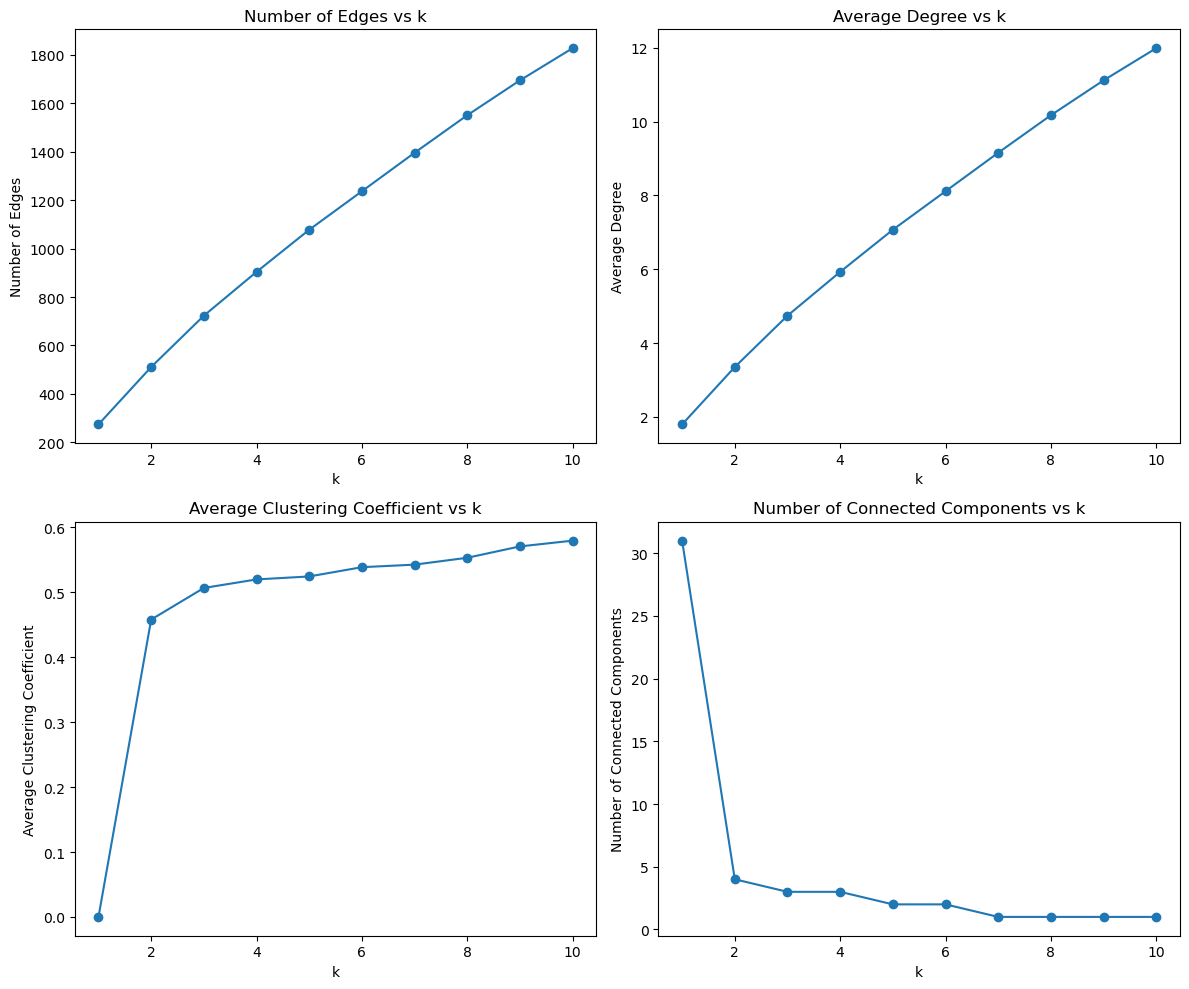

In [146]:
def analyse_knn_effect(graph, k_values):
    """
    Analyses the effect of different k values on the network properties.

    Parameters:
    graph (nx.Graph): The original NetworkX graph.
    k_values (list): List of k values to use for sparsification.

    Returns:
    pd.DataFrame: DataFrame containing the analysis results.
    """
    results = {
        'k': [],
        'num_edges': [],
        'avg_degree': [],
        'avg_clustering': [],
        'num_connected_components': [],
    }
    
    for k in k_values:
        sparsified_graph = knn_sparsification(graph, k)
        num_edges = sparsified_graph.number_of_edges()
        avg_degree = sum(dict(sparsified_graph.degree()).values()) / sparsified_graph.number_of_nodes()
        avg_clustering = nx.average_clustering(sparsified_graph)
        num_connected_components = nx.number_connected_components(sparsified_graph)
        
        results['k'].append(k)
        results['num_edges'].append(num_edges)
        results['avg_degree'].append(avg_degree)
        results['avg_clustering'].append(avg_clustering)
        results['num_connected_components'].append(num_connected_components)
    
    return pd.DataFrame(results)

def plot_knn_analysis(df):
    """
    Plots the analysis of the effect of different k values on network properties.

    Parameters:
    df (pd.DataFrame): DataFrame containing the analysis results.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0, 0].plot(df['k'], df['num_edges'], marker='o')
    axes[0, 0].set_title('Number of Edges vs k')
    axes[0, 0].set_xlabel('k')
    axes[0, 0].set_ylabel('Number of Edges')
    
    axes[0, 1].plot(df['k'], df['avg_degree'], marker='o')
    axes[0, 1].set_title('Average Degree vs k')
    axes[0, 1].set_xlabel('k')
    axes[0, 1].set_ylabel('Average Degree')
    
    axes[1, 0].plot(df['k'], df['avg_clustering'], marker='o')
    axes[1, 0].set_title('Average Clustering Coefficient vs k')
    axes[1, 0].set_xlabel('k')
    axes[1, 0].set_ylabel('Average Clustering Coefficient')
    
    axes[1, 1].plot(df['k'], df['num_connected_components'], marker='o')
    axes[1, 1].set_title('Number of Connected Components vs k')
    axes[1, 1].set_xlabel('k')
    axes[1, 1].set_ylabel('Number of Connected Components')
    
    plt.tight_layout()
    plt.show()


k_values = list(range(1, 11))  # Different k values to analyze
analysis_results = analyse_knn_effect(graphs['original'], k_values)

# Plot the analysis results
plot_knn_analysis(analysis_results)

# 8. Describing Highly Connected Nodes

In [147]:
def get_highest_degree_nodes(graph, top_n=10):
    """
    Returns the nodes with the highest degree in the graph.

    Parameters:
    graph (nx.Graph): The NetworkX graph.
    top_n (int): The number of top nodes to return.

    Returns:
    List of tuples: Each tuple contains a node and its degree.
    """
    degrees = dict(graph.degree())
    sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    return sorted_degrees[:top_n]

def fetch_gene_info(gene_list):
    """
    Fetches gene information from MyGene.info.

    Parameters:
    gene_list (list): List of gene symbols or Ensembl IDs.

    Returns:
    list: List of dictionaries containing gene information.
    """
    mg = mygene.MyGeneInfo()
    gene_info = mg.querymany(gene_list, scopes='symbol,ensembl.gene', 
                             fields='name,symbol,entrezgene,summary,disease,pathway', 
                             species='human')
    return gene_info

def print_gene_info_with_degree(top_genes_with_degrees, gene_info):
    """
    Prints gene information including the degree.

    Parameters:
    top_genes_with_degrees (list): List of tuples containing gene symbols and their degrees.
    gene_info (list): List of dictionaries containing gene information.
    """
    for gene, degree in top_genes_with_degrees:
        info = next((item for item in gene_info if item['query'] == gene), None)
        if info:
            print(f"Gene Symbol: {info.get('symbol', 'N/A')}")
            print(f"Degree: {degree}")
            print(f"Gene Name: {info.get('name', 'N/A')}")
            print(f"Entrez ID: {info.get('entrezgene', 'N/A')}")
            print(f"Summary: {info.get('summary', 'N/A')}")
            if 'disease' in info:
                diseases = ', '.join([d['term'] for d in info['disease']])
                print(f"Diseases: {diseases}")
            else:
                print("Diseases: N/A")
            if 'pathway' in info:
                pathways = []
                if isinstance(info['pathway'], dict):
                    for key in info['pathway']:
                        pathway_data = info['pathway'][key]
                        if isinstance(pathway_data, list):
                            pathways.extend([p['name'] for p in pathway_data if 'name' in p])
                        elif isinstance(pathway_data, dict) and 'name' in pathway_data:
                            pathways.append(pathway_data['name'])
                        elif isinstance(pathway_data, str):
                            pathways.append(pathway_data)
                print(f"Pathways: {', '.join(pathways) if pathways else 'N/A'}")
            else:
                print("Pathways: N/A")
            print("-" * 40)
        else:
            print(f"Gene not found: {gene}")
            print(f"Degree: {degree}")
            print("-" * 40)



In [148]:
top_genes_with_degrees = get_highest_degree_nodes(pearson_graph_pruned, top_n=10)
gene_symbols = [gene for gene, degree in top_genes_with_degrees]

# Fetch gene information
gene_info = fetch_gene_info(gene_symbols)

# Print gene information including degree
print_gene_info_with_degree(top_genes_with_degrees, gene_info)


4 input query terms found dup hits:	[('IGHJ4', 2), ('IGKV3-20', 2), ('IGKV3-11', 2), ('IGKV1-39', 2)]


Gene Symbol: IGKJ1
Degree: 118
Gene Name: immunoglobulin kappa joining 1
Entrez ID: 28950
Summary: Predicted to be involved in adaptive immune response. Predicted to be located in extracellular region and plasma membrane. Predicted to be part of immunoglobulin complex. [provided by Alliance of Genome Resources, Apr 2022]
Diseases: N/A
Pathways: N/A
----------------------------------------
Gene Symbol: MZB1
Degree: 109
Gene Name: marginal zone B and B1 cell specific protein
Entrez ID: 51237
Summary: Involved in positive regulation of cell population proliferation. Located in cytoplasm and extracellular region. [provided by Alliance of Genome Resources, Apr 2022]
Diseases: N/A
Pathways: N/A
----------------------------------------
Gene Symbol: FCRL5
Degree: 108
Gene Name: Fc receptor like 5
Entrez ID: 83416
Summary: This gene encodes a member of the immunoglobulin receptor superfamily and the Fc-receptor like family. This gene and several other Fc receptor-like gene members are clustered

Adjacency matrix shape: (305, 305)
Cluster labels for each node:
Node SPN: Cluster 5
Node SCML4: Cluster 1
Node IL2RG: Cluster 1
Node CCL23: Cluster 1
Node TLR7: Cluster 5
Node FAM30A: Cluster 4
Node LILRB4: Cluster 1
Node IGKV4-1: Cluster 3
Node CXCR6: Cluster 1
Node FCGR1A: Cluster 1
Node FCGR3A: Cluster 5
Node GVINP1: Cluster 1
Node FASLG: Cluster 1
Node GBP5: Cluster 1
Node IGKV1ORY-1: Cluster 2
Node CLEC10A: Cluster 1
Node IGKV1-16: Cluster 0
Node GBP4: Cluster 1
Node IGHV4-55: Cluster 2
Node IGLV1-47: Cluster 0
Node IGHV1-67: Cluster 2
Node IGHV4-39: Cluster 1
Node CD22: Cluster 1
Node IL2RB: Cluster 1
Node CD300LF: Cluster 5
Node MSR1: Cluster 5
Node IGHV3-30: Cluster 0
Node IRF4: Cluster 1
Node IGLV2-8: Cluster 1
Node PDCD1LG2: Cluster 1
Node IGKV1D-42: Cluster 1
Node FCRL3: Cluster 1
Node IGHV4-59: Cluster 3
Node IGLV1-50: Cluster 1
Node CD74: Cluster 1
Node IGHV1OR15-9: Cluster 2
Node F13A1: Cluster 1
Node CD48: Cluster 1
Node P2RY13: Cluster 5
Node CRTAM: Cluster 1
Node CXCR

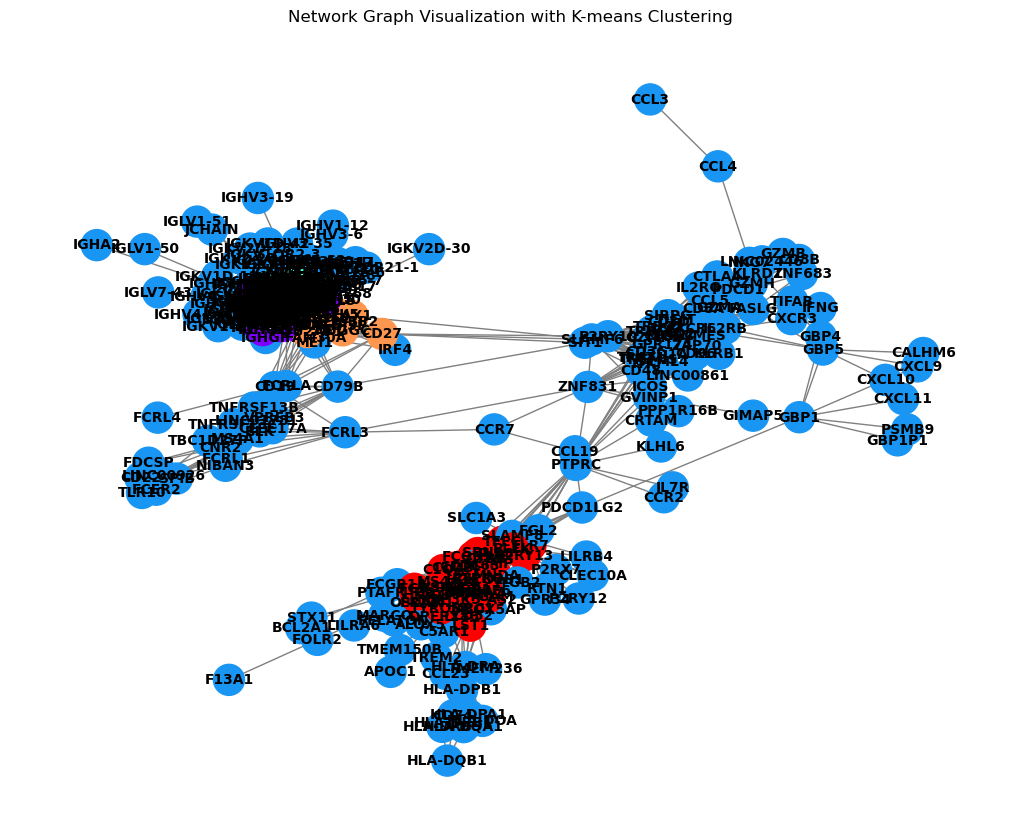

In [97]:
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

# Assuming pearson_graph_pruned is your graph object
adj_matrix = nx.to_numpy_array(pearson_graph_pruned)

# Verify the shape of the adjacency matrix
print(f"Adjacency matrix shape: {adj_matrix.shape}")

# Number of clusters
k = 6

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(adj_matrix)

# Get cluster labels for each node
labels = kmeans.labels_

# Map nodes to their corresponding cluster labels
node_to_index = {node: index for index, node in enumerate(pearson_graph_pruned.nodes())}
index_to_node = {index: node for node, index in node_to_index.items()}

# Print cluster labels for each node
print("Cluster labels for each node:")
for index, label in enumerate(labels):
    node = index_to_node[index]
    print(f"Node {node}: Cluster {label}")

# Draw the graph with nodes colored by their cluster label
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(pearson_graph_pruned)

# Assign colors to nodes based on their cluster label
node_colors = [labels[node_to_index[node]] for node in pearson_graph_pruned.nodes()]

# Draw the graph
nx.draw(pearson_graph_pruned, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.rainbow, node_size=500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Network Graph Visualization with K-means Clustering")
plt.show()



# Storing generated networks

In [ ]:
#example
nx.write_gml(pearson_graph_pruned, 
             os.path.join(intermediate_data_dir,'gene_coexpression_network.gml'))


# Interactive Visualization

In [ ]:
def save_interactive_network_plotly(graph, output_file='network.html', title="Interactive Network"):
    # Extract node positions
    pos = nx.spring_layout(graph)

    # Extract edges
    edge_x = []
    edge_y = []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Extract nodes
    node_x = []
    node_y = []
    node_text = []
    for node in graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(str(node))

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper"
                        )],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )

    # Save the figure to an HTML file
    pio.write_html(fig, file=output_file, auto_open=True)

In [ ]:
save_interactive_network_plotly(pearson_graph_pruned, 
                                output_file=os.path.join(intermediate_data_dir,'genecoexp_plotly_network.html'), title="Gene Coexpression Network")
